# Participant report

This section aims at gathering the different information that could appear in an administration report. It will most likely be hierarchical with the most important information presented firt, followed by
the details.

1) Demographics of the participant and clinical data if available
2) Quality of the administration: missing data, compliance score
3) Prediction for the participant and interpretability resultd


If time allows, and if we think ut's necessary we can add (i) the distribution of the participant's face proportion of the screen and the actual participant point, (ii) Percentage of frame where the face where detected, etc. 

In [1]:
run init.ipynb

Done.


In [51]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:1F77B4-46.2:FFFFFF-100:FF7F0E
    (0.000, (0.122, 0.467, 0.706)),
    (0.462, (1.000, 1.000, 1.000)),
    (1.000, (1.000, 0.498, 0.055))))
csfont = {'fontname':'Times New Roman'}

def display_interaction_summary(matrix_shap):
    
    principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
    interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

    dict_shap = {}
    for i, feat in enumerate(exp.features_name):

        main_effect = np.abs(matrix_shap)[i,i]
        interaction_effect = np.abs(matrix_shap)[i].sum() - main_effect

        row_shap = deepcopy(np.abs(matrix_shap)[i])
        row_shap[i] = 0
        first_interaction = np.max(row_shap)
        first_interaction_name = exp.features_name[np.argmax(row_shap)]

        dict_shap[feat] = {'total': main_effect+interaction_effect, 'main': main_effect, 'interaction': interaction_effect, 'first_interaction': first_interaction, 'first_interaction_name': first_interaction_name}
    final_interactions_summary = pd.DataFrame(dict_shap).transpose().sort_values('total', ascending=False)
    final_interactions_summary = final_interactions_summary.append(pd.DataFrame([[100, principal_effect_sum, interaction_effect_sum, '', '']], index=['SUM'], columns = final_interactions_summary.columns))

    return final_interactions_summary


def plot_app_featurees_summary(exp, df_shap_summary, index_sample):
    from utils import select
    from matplotlib import rc
    plt.rcParams["font.serif"] = "Times New Roman"

    participant_id = exp.dataset.df.iloc[index_sample]['id']
    age = exp.dataset.df.iloc[index_sample]['age']
    sex = exp.dataset.df.iloc[index_sample]['sex']
    diagnosis = exp.dataset.df.iloc[index_sample]['diagnosis']
    

    n_plots = len(exp.features_name)
    fig, axes = plt.subplots(n_plots//3+1, 3, figsize=(35, 32));axes = axes.flatten()
    fig.suptitle("App features summary for participant :{}\nSex: {} - Age (in months): {:.1f} - {}".format(participant_id, sex, age, diagnosis), y=1.02, weight="bold", fontsize=22, **csfont)
    for i, feat in enumerate(list(df_shap_summary.index)):
        if feat == 'SUM':
            continue

        total_contrib =  df_shap_summary.loc[feat, 'total']
        main_contrib =  df_shap_summary.loc[feat, 'main']
        x_contrib =  df_shap_summary.loc[feat, 'interaction']
        confidence = exp.dataset.df.iloc[index_sample]['{}_conf'.format(feat)]

        title = r"$\bf{" + str(feature_name_mapping[feat].replace(" ", "\ ")) + "}$\n"




        title+=r"$\bf{" + "Confidence\ score: {}".format(confidence) +  "}$\n"

        title+=r"$\bf{Contributions: }$"
        title+="Principal: {:.1f}% - Interactions: {:.1f}% ".format(main_contrib, x_contrib)
        title+= r"$\bf(Total: {:.1f})$".format(total_contrib)  

        _, bins = np.histogram(select(exp.dataset.df, 'diagnosis', 0)[feat].dropna().to_numpy())
        
        
        sns.distplot(select(exp.dataset.df, 'diagnosis', 0)[feat].to_numpy(), bins=bins, label='NT',  color='tab:blue', ax=axes[i], kde_kws=dict(bw=0.4, lw=3))
        sns.distplot(select(exp.dataset.df, 'diagnosis', 1)[feat].to_numpy(), bins=bins, label='Autistic', rug=True,  color='tab:orange', ax=axes[i], kde_kws=dict(bw=0.4, lw=3))
        axes[i].set_title(title, y=1.02, fontsize=20, **csfont); axes[i].set_xlabel("Value", weight='bold', fontsize=20, **csfont)
        axes[i].set_yticks([]); axes[i].grid();y_min, y_max = axes[i].get_ylim(); axes[i].set_ylabel("Density", fontsize=20, **csfont)
        axes[i].set_xticks(axes[i].get_xticks(), np.round(axes[i].get_xticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)


        axes[i].scatter([exp.dataset.df.iloc[index_sample][feat]], [0.1*(y_max-y_min)], s=200, color='tab:red')


    plt.tight_layout()
    plt.savefig(os.path.join(ROOT_DIR, 'figures_final', '{}_summary.png'.format(participant_id)), dpi=200, bbox_inches = 'tight')
    plt.show()
    return

class waterfall():
        def __init__(self, data, shap_values, 
                           base_value, 
                           path = "",
                           green_color ='#1F77B4' , 
                           red_color = '#FF7F0E', 
                           n=12,
                           title="The Prediction " ,
                           x_lab="",
                           y_lab="The predicted value",
                           formatting = "{:,.2f}",
                           rotation_value = 90,
                           figsize = (30,10)

                    ):
            self.data        = data
            self.shap_values = shap_values
            self.base_value  = base_value
            self.green_color = green_color
            self.red_color   = red_color
            self.n           = n
            self.title       = title
            self.x_lab       = x_lab
            self.y_lab       = y_lab
            self.formatting  = formatting
            self.rotation_value = rotation_value
            self.figsize     = figsize
            self._plot       = pd.DataFrame()
            self.path        = path

        def obs_to_explain(self):
            '''
              - data: the observation. It is a Pandas series. The index contains the variable names 
              - shap_values: the shap_values for the above observation 
              - base_value: the base_value, which is the expected value or the mean of the target value of the training set
              - green_color: the color for the up bar
              - red_color: the color for the down bar
              - for_plot: a sorted data frame by the absolute value of shape in descending order
              - n: show the top n (default) variables. The rest variables are summed up into "others"
            '''
            for_plot = pd.DataFrame({'data':self.data.round(2),
                                     'shap':self.shap_values,
                                     'shap_abs': np.abs(self.shap_values),
                                     'label': self.data.index
                                    })
            for_plot = for_plot.sort_values(by='shap_abs',ascending=False)

            # Split the variables into n and the rest. Only show the top n
            for_plot1 = for_plot.iloc[0:self.n,:]
            for_plot2 = for_plot.iloc[self.n:,:]

            # Sum up the rest as 'others'
            rest = pd.DataFrame({'data': '','shap':for_plot2['shap'].sum(), 'label': 'Others'},index=['others'])
            for_plot = for_plot1.append(rest)

            # Sum up the rest into 'others'
            for_plot = for_plot

            for_plot['blank'] = for_plot['shap'].cumsum().shift(1).fillna(0) # +  base_value
            for_plot['label'] = + for_plot['label'] + " = " + for_plot['data'].map(str) 
            for_plot['color'] = np.where(for_plot['shap']>0,self.green_color, self.red_color)
            for_plot = for_plot.drop(['data','shap_abs'],axis=1)

            self.for_plot = for_plot

            return(for_plot) 

        def plot(self, exp, index_sample):
            '''
              - x_lab, y_lab: the x label and y label
              - formatting: show the value of each bar 
            '''
            csfont = {'fontname':'Times New Roman'}
            from matplotlib.colors import Normalize
            norm = Normalize(vmin=-10, vmax=10)
        
            df_waterfall = self.obs_to_explain()
            feature_name_mapping_reverse = {k:v for v, k in feature_name_mapping.items()}
            
            from matplotlib import rc
            plt.rcParams["font.serif"] = "Times New Roman"
            plt.figure(figsize=(self.figsize))

            y = len(df_waterfall)
            left = 0
            confidence_str = ""
            for i, row in df_waterfall.iterrows():

                plt.arrow(left, y, row['shap'], 0, width=0.3, length_includes_head=True, head_width=0.6, shape='full', color = cmap(norm(row['shap'])))# if row['shap']>0 else 'left', color='red')

                left = left + row['shap']

                pos_offset = 1
                if row['shap'] > 0:
                        plt.annotate(self.formatting.format(row['shap']),(left+pos_offset, y-0.15),ha="center", color = self.red_color, fontsize=20, weight='bold', **csfont)
                else:
                        plt.annotate(self.formatting.format(row['shap']),(left-pos_offset, y-0.15), ha="center", color = self.green_color, fontsize=20, weight='bold', **csfont)

                y-=1
                
                if i != 'others': 
                    confidence = exp.dataset.df.iloc[index_sample]['{}_conf'.format(feature_name_mapping_reverse[i])]
                    confidence_str+= "{}: {:.2f}\n".format(i, confidence)

                

            plt.yticks(ticks = list(reversed(range(1,len(self.for_plot.index)+1))), labels = df_waterfall['label'], weight='bold', fontsize=20, **csfont)
            plt.xticks(weight='bold', fontsize=20, **csfont)
            plt.gca().xaxis.grid(True)  #plt.grid()

            plt.title(self.title, weight="bold", fontsize=22, **csfont)
            participant_id = exp.dataset.df.iloc[index_sample]['id']
            plt.savefig(os.path.join(ROOT_DIR, 'figures', '{}_waterfall.png'.format(participant_id)), dpi=200, bbox_inches = 'tight')
            plt.show()
            print(confidence_str)
            

def waterfall_plot(exp, matrix_shap, index_sample):

    data_df = deepcopy(exp.dataset.df)
    
    participant_id = exp.dataset.df.iloc[index_sample]['id']
    age = exp.dataset.df.iloc[index_sample]['age']
    sex = exp.dataset.df.iloc[index_sample]['sex']
    diagnosis = exp.dataset.df.iloc[index_sample]['diagnosis']
    title = "App features summary for participant :{}\nSex: {} - Age (in months): {:.1f} - {}".format(participant_id, sex, age, diagnosis)
        
    data_df.rename(columns=feature_name_mapping, inplace=True)
    shap_object = waterfall(data=data_df.iloc[index_sample:index_sample+1].round(2)[[feature_name_mapping[f] for f in exp.features_name]].iloc[0], 
                            base_value=0, 
                            shap_values=matrix_shap.sum(axis=0), 
                            path = "./",
                          title=title,
                          x_lab="",
                          y_lab="The predicted value",
                          formatting = "{:,.2f}",
                          rotation_value = 90,
                          figsize = (20,7)                       
                           )
    shap_object.plot(exp, index_sample)
        
    

    return


def report_participant(exp, index_sample):

    #exp.dataset.df['sex'] = exp.dataset.df['sex'].replace({0: "F", 1: "M"})
    #exp.dataset.df['diagnosis'] = exp.dataset.df['sex'].replace({0: "Neurotypical", 1: "Autistic", 2:"LD-DD"})

    participant_id = exp.dataset.df.iloc[index_sample]['id']
    age = exp.dataset.df.iloc[index_sample]['age']
    sex = exp.dataset.df.iloc[index_sample]['sex']
    diagnosis = exp.dataset.df.iloc[index_sample]['diagnosis']



    # Draw a random smaple and plot the shap matrix
    matrix_shap = averaged_shap_interactions_normalized[index_sample]*100

    # Build the anotation matrix for ploting
    max_value = np.max(np.abs(matrix_shap))
    df_shap = pd.DataFrame(matrix_shap, columns = exp.features_name, index = exp.features_name)
    df_shap_label = np.zeros_like(matrix_shap).astype(str)
    for row in range(matrix_shap.shape[0]):
        for col in range(matrix_shap.shape[0]):

            if np.abs(matrix_shap[row, col]) > 1: 
                df_shap_label[row, col] = str(np.round(matrix_shap[row, col], 1))
            else:
                df_shap_label[row, col] = ""

    principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
    interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

    fi(15, 15)
    plt.title("Normalized Shap matrix for participant: {}\nPrincipal contributions: {:.1f}% | Interractions: {:.1f}%".format(index_sample, principal_effect_sum, interaction_effect_sum), weight='bold')
    sns.heatmap(df_shap, cmap=cmap, vmin=-max_value, vmax=max_value, fmt="", annot=df_shap_label)
    plt.show()
    df_shap_summary = display_interaction_summary(matrix_shap)
    display(df_shap_summary)
    plot_app_featurees_summary(exp, df_shap_summary, index_sample)
    waterfall_plot(exp, matrix_shap, index_sample)
    
    return 

**We first need to retrieve the participant's data**

In [52]:

use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    

df_data =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df_data, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='15_December_final_regular_weighted_K50', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'Supreme',
                  verbosity=1, 
                  save_experiment=False)



In [6]:
from utils import create_autism_df
df = create_autism_df(folder_names = ['multimodal_paper_final'])

100%|██████████| 1001/1001 [06:12<00:00,  2.68it/s]


In [53]:
exp.dataset.df

id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking        age timestamp       date   time study stimuli_version  sex  ethnicity  race  primary_education  asd_yn  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay valid_name_calls  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  MP_postural_sway  \
0    810004        0.0  English         1.0  <Subject.S2KSubject object at 0x7fea91cd4410>  <Administration.S2KAdministration object at 0x...                   1              1  24.262295    Admin1 2019-03-05  00:00    P1       Preschool  1.0        0.0   0.0                6.0     NaN        NaN        NaN        NaN        NaN             NaN         NaN       NaN      NaN              39.0                         43.0                          41.0                 0.0             0.0          0.0          0.0           0.0               0.272102                  0.664593              0.618125                 0.813907                    0.525349                  0.853205                           0.000000                             NaN        [1, 1, 1]          0.712622                     0.005118            0.179620                       0.000383              0.194684                         0.000343          0.195667                     0.000350          0.218345   
1    810045        1.0  English         2.0  <Subject.S2KSubject object at 0x7fea91ce2310>  <Administration.S2KAdministration object at 0x...                   1              1  29.901639    Admin1 2019-09-06  00:00    P1       Preschool  0.0        0.0   1.0                5.0     NaN        NaN        NaN        NaN        NaN             NaN         NaN       NaN      NaN               NaN                          NaN                           NaN                 1.0             4.0          2.0          2.0           0.0               0.453815                  0.292254              0.585477                 0.409994                    0.087725                  0.476764                           1.000000                        0.556111        [1, 1, 1]          2.412340                     0.005602            1.829033                       0.006003              2.451308                         0.010101          1.851600                     0.006547          1.337042   
2    810048        0.0  English         1.9  <Subject.S2KSubject object at 0x7fea91ce6090>  <Administration.S2KAdministration object at 0x...                   1              1  24.721311    Admin1 2019-03-29  00:00    P1       Preschool  1.0        1.0   0.0                6.0     NaN        NaN        NaN        NaN        NaN             NaN         NaN       NaN      NaN               NaN                          NaN                           NaN                 1.0             1.0          0.0          0.0           0.0               0.406832                  0.581609              0.560275                 0.737280                    0.182405                  0.625747                           0.000000                             NaN        [0, 1, 0]          2.736065                     0.021593            0.786138                       0.007086              0.488317                         0.002453          0.140298                     0.000221          0.884768   
3    810051        1.0  English         1.0  <Subject.S2KSubject 

In [10]:
from utils import compute_performances
performances_df = compute_performances(df)
#performances_df.to_csv("/home01/sam/notes_on_stats/doc/src/data/dataframe/performances_multimodal_paper.csv", index=False)

performances_df 

name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Corrected NPV  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN  optimal_threshold  num_samples  TN_normalized  TP_normalized  FP_normalized  FN_normalized    N                                             y_true                                             y_pred  Hanley_CI
\n(N=377)  \n(N=377)  0.899   0.622        0.935             0.222                  0.953                           0.545               0.161  0.712         0.315     0.817                                   0.513                                              0.878                                                       0.808                                            0.406                                              0.088               0.997                            0.978                                   0.122                             0.594                            0.022  43  265  63   6              0.378          377      70.291777      11.405836      16.710875       1.591512  377  [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...  [0.001, 1.0, 0.001, 0.775, 0.27, 0.283, 0.177,...   0.030085

In [64]:
performances_df

name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Corrected NPV  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN  optimal_threshold  num_samples  TN_normalized  TP_normalized  FP_normalized  FN_normalized    N                                             y_true                                             y_pred  Hanley_CI
\n(N=377)  \n(N=377)  0.899   0.622        0.935             0.222                  0.953                           0.545               0.161  0.712         0.315     0.817                                   0.513                                              0.878                                                       0.808                                            0.406                                              0.088               0.997                            0.978                                   0.122                             0.594                            0.022  43  265  63   6              0.378          377      70.291777      11.405836      16.710875       1.591512  377  [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...  [0.001, 1.0, 0.001, 0.775, 0.27, 0.283, 0.177,...   0.030085

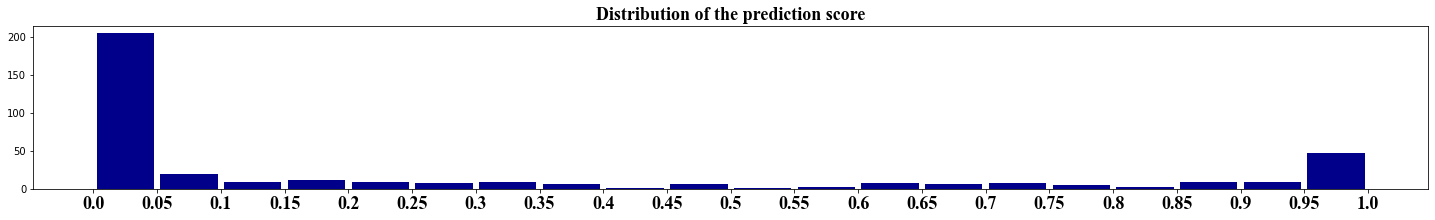

In [13]:
conslusiveness_score = performances_df.iloc[0]['y_pred']

fi(25, 3)
plt.hist(conslusiveness_score, bins=np.arange(0, 1.05, .05), color='darkblue', rwidth = 0.9)
plt.title("Distribution of the prediction score", weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.savefig(os.path.join(ROOT_DIR, 'figures_final', 'conclusiveness_nt_asd.png'), dpi=200, bbox_inches = 'tight')
None

In [66]:
np.sum(conslusiveness_score <= 0.2)

243

In [67]:
np.sum(conslusiveness_score >= 0.8)

68

In [68]:
243+68

311

In [72]:
66/377

0.17506631299734748

In [71]:
377-311

66

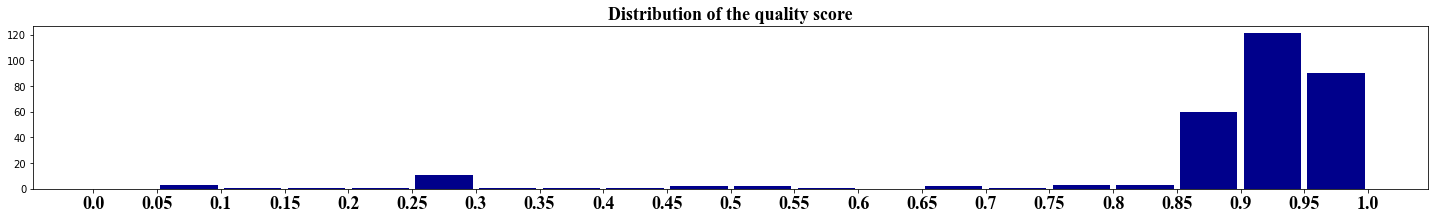

In [12]:
quality_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))

fi(25, 3)
plt.hist(quality_score, bins=np.arange(0, 1.05, .05), color='darkblue', rwidth = 0.9)
plt.title("Distribution of the quality score", weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.savefig(os.path.join(ROOT_DIR, 'figures_final', 'quality_nt_asd.png'), dpi=200, bbox_inches = 'tight')
None

**Retrieve their quality score and conclusiveness score**

In [55]:
exp.dataset.df['conslusiveness_score'] = conslusiveness_score
exp.dataset.df['quality_score'] = quality_score

In [54]:

if True:
    
    exp.dataset.df['S_blink_rate_conf'] = (~exp.dataset.df[['MML_blink_rate', 'FP_blink_rate', 'PWB_blink_rate']].isna()).sum(axis=1)/3
    exp.dataset.df['NS_blink_rate_conf'] = (~exp.dataset.df[['DIGC_blink_rate', 'DIGRRL_blink_rate', 'FB_blink_rate', 'MP_blink_rate']].isna()).sum(axis=1)/4

    
    exp.dataset.df['S_postural_sway_conf'] = (~exp.dataset.df[['ST_postural_sway', 'BB_postural_sway', 'MML_postural_sway', 'FP_postural_sway', 'PWB_postural_sway']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_postural_sway_conf'] = (~exp.dataset.df[['DIGC_postural_sway', 'DIGRRL_postural_sway', 'FB_postural_sway', 'MP_postural_sway']].isna()).sum(axis=1)/4
   
    exp.dataset.df['S_postural_sway_derivative_conf'] = (~exp.dataset.df[['ST_postural_sway_derivative', 'BB_postural_sway_derivative', 'MML_postural_sway_derivative', 'FP_postural_sway_derivative', 'PWB_postural_sway_derivative']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_postural_sway_derivative_conf'] = (~exp.dataset.df[['DIGC_postural_sway_derivative', 'DIGRRL_postural_sway_derivative', 'FB_postural_sway_derivative', 'MP_postural_sway_derivative']].isna()).sum(axis=1)/4
    
    exp.dataset.df['gaze_silhouette_score_conf'] = (~exp.dataset.df[['BB_gaze_silhouette_score','S_gaze_silhouette_score']].isna()).sum(axis=1)/2
    exp.dataset.df['mean_gaze_percent_right_conf'] = (~exp.dataset.df[['S_gaze_percent_right','BB_gaze_percent_right']].isna()).sum(axis=1)/2
    exp.dataset.df['FP_gaze_speech_correlation_conf'] = (~exp.dataset.df[['FP_gaze_speech_correlation']].isna()).sum(axis=1)

    exp.dataset.df['S_facing_forward_conf'] = (~exp.dataset.df[['ST_facing_forward', 'BB_facing_forward', 'MML_facing_forward', 'FP_facing_forward', 'PWB_facing_forward']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_facing_forward_conf'] = (~exp.dataset.df[['DIGC_facing_forward', 'DIGRRL_facing_forward', 'FB_facing_forward', 'MP_facing_forward']].isna()).sum(axis=1)/4

    exp.dataset.df['S_eyebrows_complexity_conf'] = (~exp.dataset.df[['ST_eyebrows_complexity', 'BB_eyebrows_complexity', 'MML_eyebrows_complexity', 'FP_eyebrows_complexity', 'PWB_eyebrows_complexity']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_eyebrows_complexity_conf'] = (~exp.dataset.df[['DIGC_eyebrows_complexity', 'DIGRRL_eyebrows_complexity', 'FB_eyebrows_complexity', 'MP_eyebrows_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_mouth_complexity_conf'] = (~exp.dataset.df[['ST_mouth_complexity', 'BB_mouth_complexity', 'MML_mouth_complexity', 'FP_mouth_complexity', 'PWB_mouth_complexity']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_mouth_complexity_conf'] = (~exp.dataset.df[['DIGC_mouth_complexity', 'DIGRRL_mouth_complexity', 'FB_mouth_complexity', 'MP_mouth_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_postural_sway_complexity_conf'] = (~exp.dataset.df[['ST_head_movement_complexity', 'BB_head_movement_complexity', 'MML_head_movement_complexity', 'FP_head_movement_complexity', 'PWB_head_movement_complexity']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_postural_sway_complexity_conf'] = (~exp.dataset.df[['DIGC_head_movement_complexity', 'DIGRRL_head_movement_complexity', 'FB_head_movement_complexity', 'MP_head_movement_complexity']].isna()).sum(axis=1)/4


    exp.dataset.df['RTN_conf'] = exp.dataset.df['valid_name_calls'].apply(lambda x: np.sum(x))/3
    exp.dataset.df['touch_conf'] = exp.dataset.df['number_of_touches'].apply(lambda x: 0 if np.isnan(x) else x/15  if x <=15 else 1. if x>= 16 else 0)



**Compute Shap Values using the experiment that were run with all features, in the `paper_uncertianinty` notebook**

In [17]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/multimodal_paper_final/SenseToKnow/'
json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)

# Normalize the Shap Values for each sample so that there are comparables. 
shap_interactions_normalized = shap_interactions / np.abs(shap_interactions).sum(axis=3).sum(axis=2)[:, :, np.newaxis, np.newaxis]

# Average the Shap values over the different experiments 
averaged_shap_interactions = shap_interactions_normalized.mean(axis=0)

# Re-normalize the Shap values
averaged_shap_interactions_normalized  = averaged_shap_interactions/np.abs(averaged_shap_interactions).sum(axis=2).sum(axis=1)[:, np.newaxis, np.newaxis]

In [18]:
principal_effect_sum = np.mean([np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])
principal_effect_sum_std = np.std([np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])

interaction_effect_sum = np.mean([np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])
interaction_effect_sum_std = np.std([np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])

print("Principal contribution of each features: {:.3f} (+/- {:.3f}), and interaction effect: {:.3f} (+- {:.3f}%)".format(principal_effect_sum, principal_effect_sum_std, interaction_effect_sum, interaction_effect_sum_std ))

Principal contribution of each features: 0.646 (+/- 0.034), and interaction effect: 0.354 (+- 0.034%)


**Select a promising participant to showcase**

quality_score  conslusiveness_score
66       0.963815                   1.0

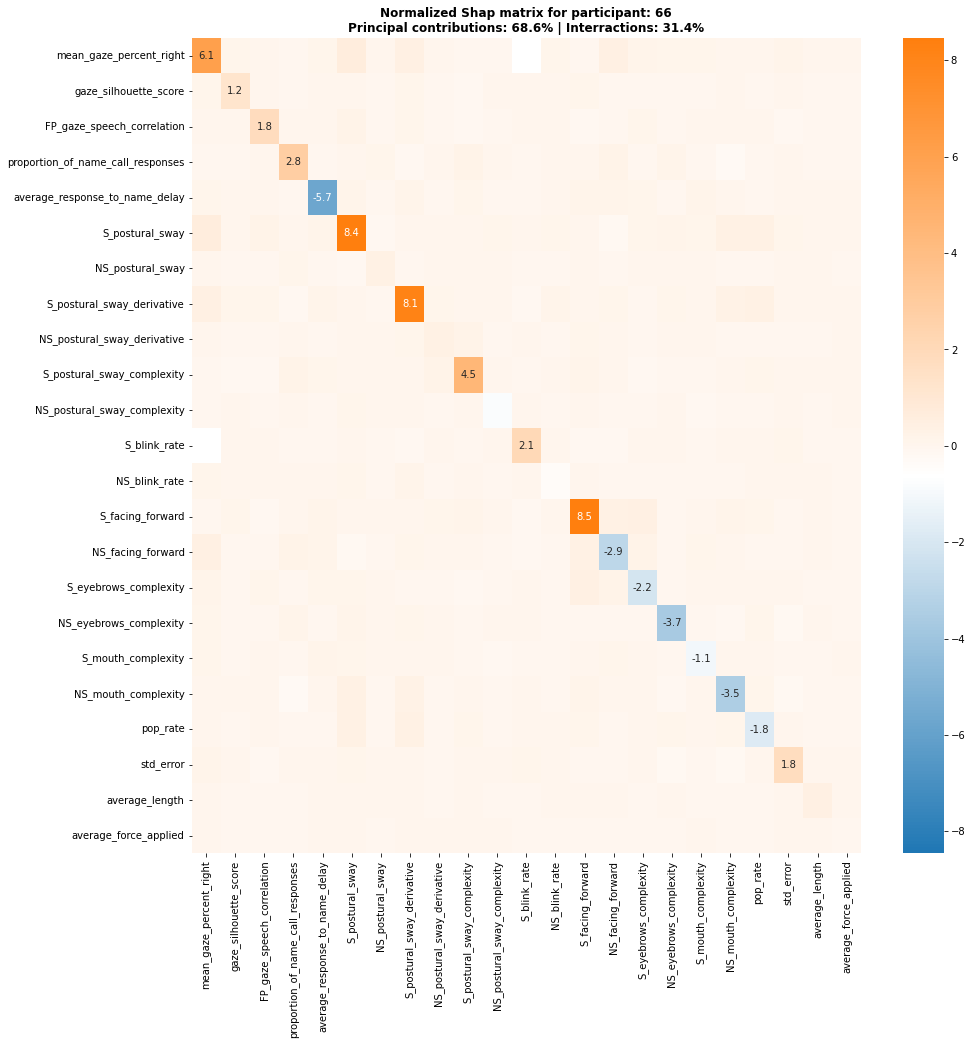

total       main interaction first_interaction             first_interaction_name
S_postural_sway                    11.321751   8.396408    2.925344          0.634056            mean_gaze_percent_right
S_postural_sway_derivative         10.636621   8.147469    2.489152          0.447399            mean_gaze_percent_right
S_facing_forward                    10.46751   8.458736    2.008774           0.41249              S_eyebrows_complexity
mean_gaze_percent_right             9.482095   6.136859    3.345236          0.634056                    S_postural_sway
average_response_to_name_delay      7.255759   5.692529     1.56323          0.197752         S_postural_sway_derivative
S_postural_sway_complexity          5.889592   4.491909    1.397683          0.243382        NS_postural_sway_derivative
NS_mouth_complexity                 5.223933   3.484018    1.739915          0.373582                    S_postural_sway
NS_facing_forward                   5.092995   2.912997    2.179998          0.438243            mean_gaze_percent_right
NS_eyebrows_complexity              4.989855   3.676605     1.31325          0.195684                    S_postural_sway
proportion_of_name_call_responses     4.1451     2.8305      1.3146          0.258086                NS_mouth_complexity
S_eyebrows_complexity               3.633504   2.162563    1.470941           0.41249                   S_facing_forward
S_blink_rate                        3.513206   2.066511    1.446695          0.626304            mean_gaze_percent_right
FP_gaze_speech_correlation          3.013097   1.847533    1.165564           0.21329                    S_postural_sway
pop_rate                            2.971768   1.789717    1.182051          0.368455         S_postural_sway_derivative
std_error                           2.901476   1.769347    1.132129          0.183973             NS_eyebrows_complexity
gaze_silhouette_score                2.01787   1.228999    0.788871          0.118001         S_postural_sway_complexity
S_mouth_complexity                  1.992038   1.118193    0.873845          0.187562     average_response_to_name_delay
NS_postural_sway_complexity         1.267795   0.847417    0.420378           0.08784                    S_postural_sway
NS_postural_sway_derivative         1.232748    0.33495    0.897799          0.243382         S_postural_sway_complexity
NS_blink_rate                       1.108441   0.362816    0.745625          0.138578         S_postural_sway_derivative
NS_postural_sway                    0.944236   0.382154    0.562082          0.082239  proportion_of_name_call_responses
average_length                      0.696108   0.405212    0.290896          0.054647             NS_eyebrows_complexity
average_force_applied               0.202501   0.025845    0.176656          0.046665                    S_postural_sway
SUM                                      100  68.569287   31.430713

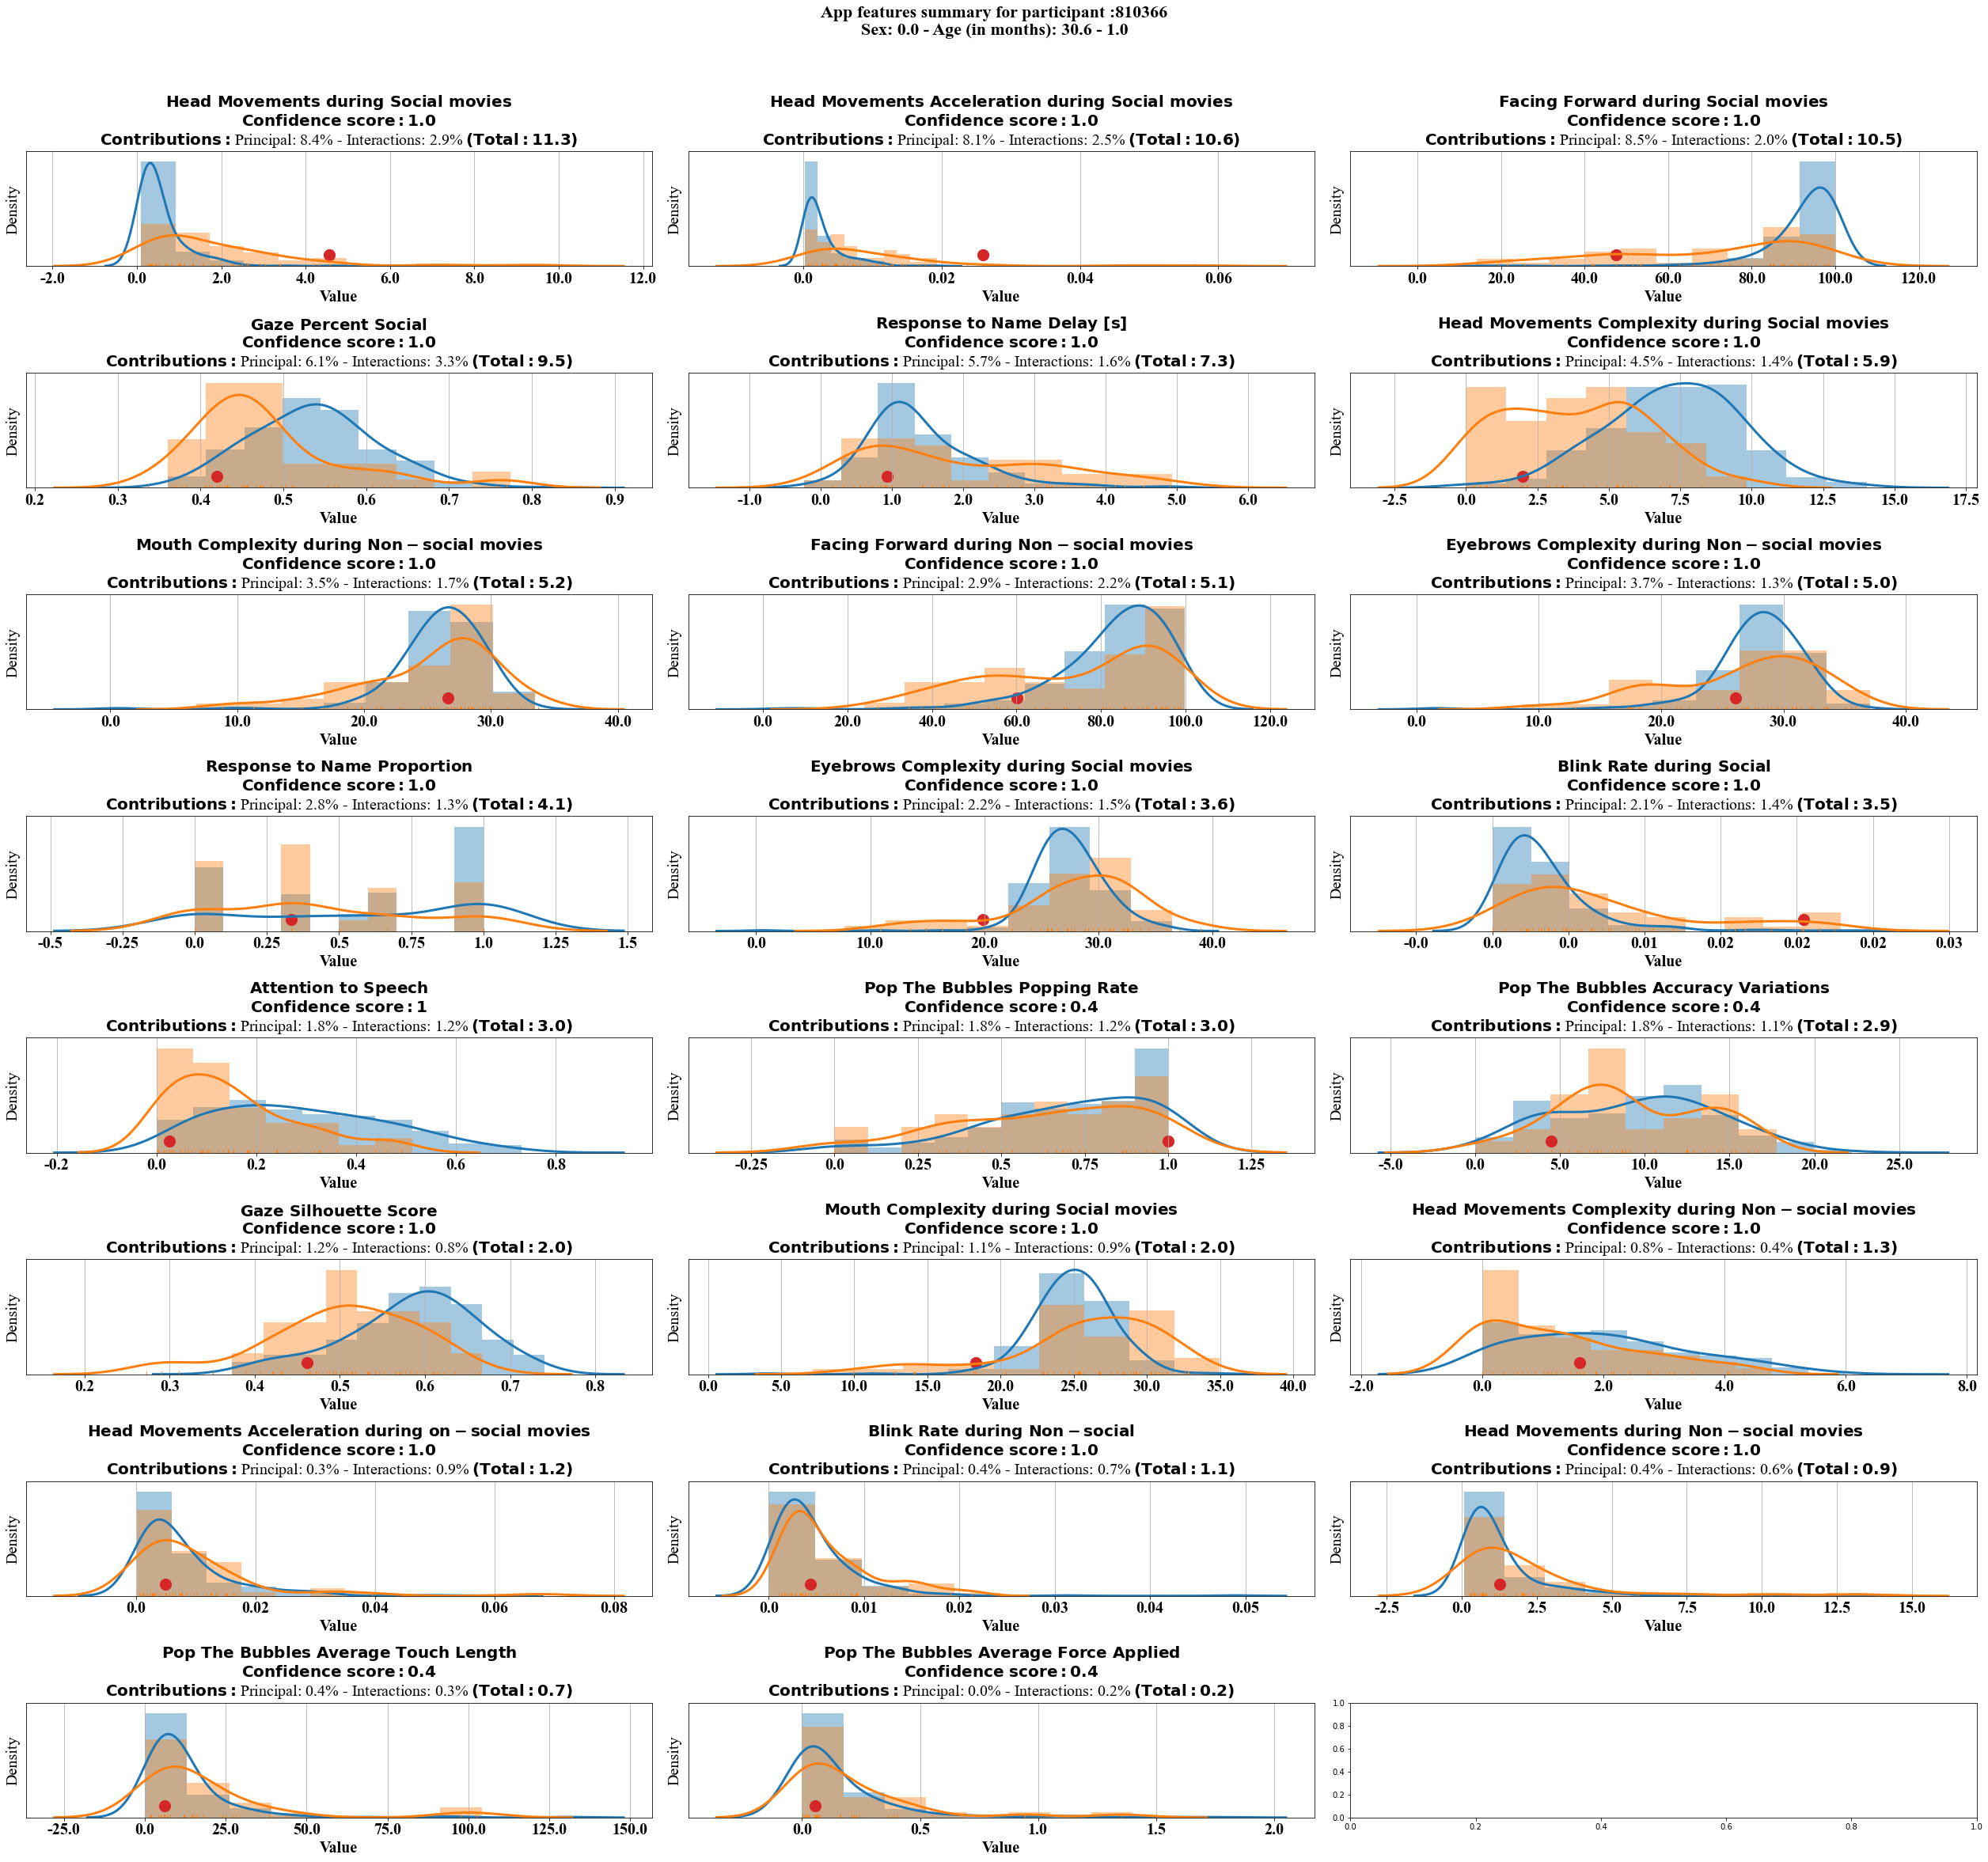

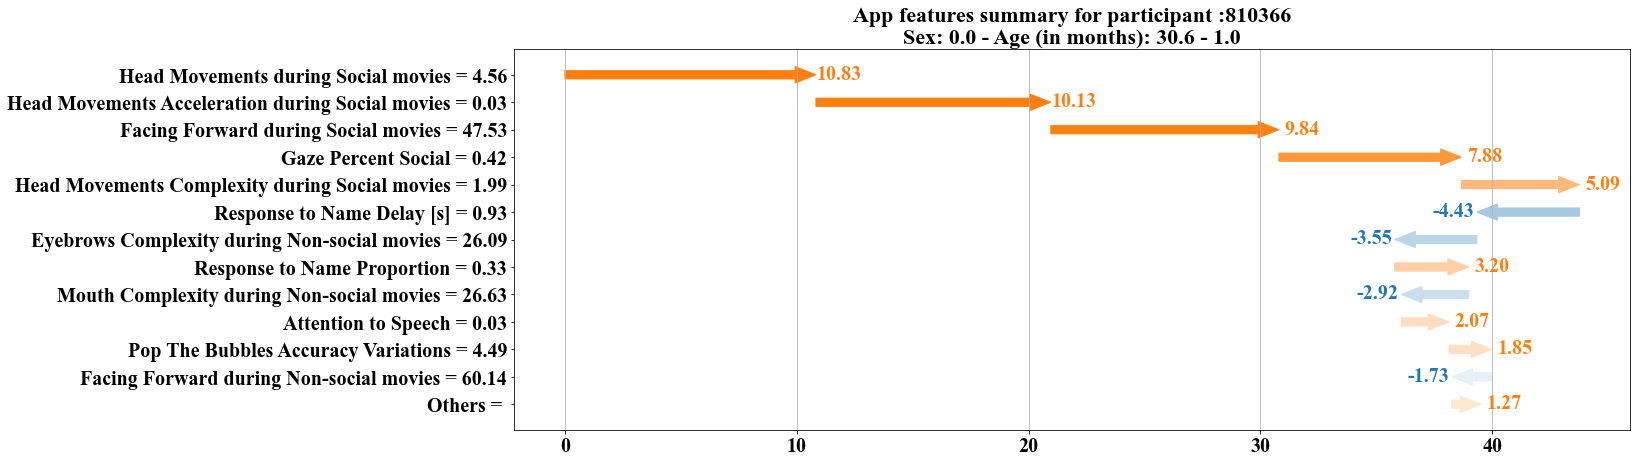

Head Movements during Social movies: 1.00
Head Movements Acceleration during Social movies: 1.00
Facing Forward during Social movies: 1.00
Gaze Percent Social: 1.00
Head Movements Complexity during Social movies: 1.00
Response to Name Delay [s]: 1.00
Eyebrows Complexity during Non-social movies: 1.00
Response to Name Proportion: 1.00
Mouth Complexity during Non-social movies: 1.00
Attention to Speech: 1.00
Pop The Bubbles Accuracy Variations: 0.40
Facing Forward during Non-social movies: 1.00



In [56]:
index_sample = 66
display(exp.dataset.df.iloc[index_sample:index_sample+1][['quality_score', 'conslusiveness_score']])
report_participant(exp, index_sample)

**Show a NT participant**

quality_score  conslusiveness_score
165            1.0                   0.0

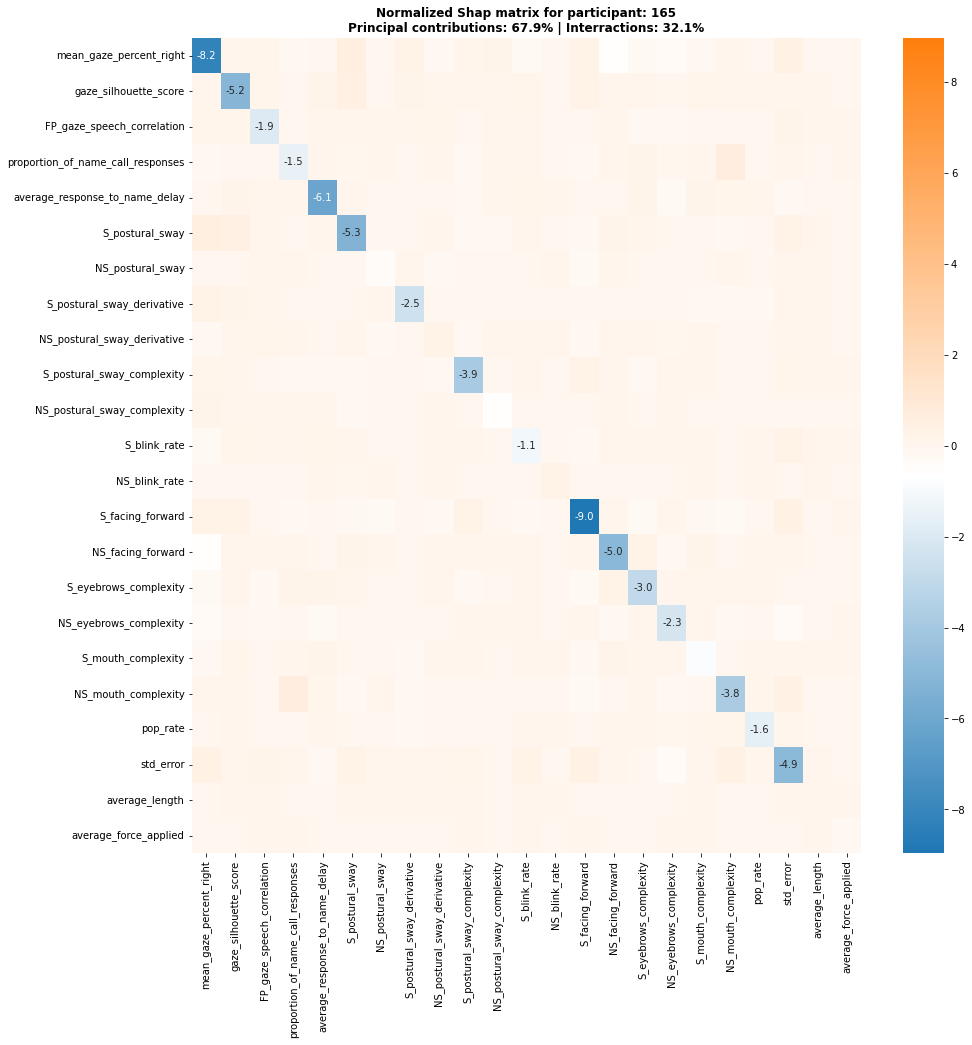

total       main interaction first_interaction             first_interaction_name
mean_gaze_percent_right            12.256517   8.240355    4.016162          0.564629                  NS_facing_forward
S_facing_forward                    11.56554   8.969353    2.596187          0.399824                          std_error
average_response_to_name_delay      7.711328   6.113992    1.597336          0.243766             NS_eyebrows_complexity
std_error                           7.603187   4.921526    2.681661          0.411982                NS_mouth_complexity
S_postural_sway                      7.50895   5.323668    2.185282          0.541189            mean_gaze_percent_right
gaze_silhouette_score               6.764437   5.161939    1.602499          0.420466                    S_postural_sway
NS_facing_forward                   6.678435   5.002831    1.675604          0.564629            mean_gaze_percent_right
NS_mouth_complexity                 5.916671   3.823562    2.093109          0.593867  proportion_of_name_call_responses
S_postural_sway_complexity          5.173401    3.85729    1.316111          0.306034                   S_facing_forward
S_eyebrows_complexity               4.451166   2.988035    1.463131          0.273357                  NS_facing_forward
NS_eyebrows_complexity              3.872442   2.268837    1.603605          0.302421                          std_error
S_postural_sway_derivative          3.635385   2.496472    1.138912          0.342144            mean_gaze_percent_right
FP_gaze_speech_correlation            3.0554   1.897121     1.15828          0.172182                          std_error
proportion_of_name_call_responses   2.897766   1.493018    1.404748          0.593867                NS_mouth_complexity
S_blink_rate                        2.239882   1.128968    1.110914          0.265918            mean_gaze_percent_right
pop_rate                            2.207025    1.63497    0.572054            0.1069         S_postural_sway_derivative
S_mouth_complexity                  1.981419   0.860144    1.121275          0.178154     average_response_to_name_delay
NS_postural_sway_complexity         1.101768   0.605343    0.496425          0.146408            mean_gaze_percent_right
NS_postural_sway                    1.068416   0.350405    0.718011          0.217331                   S_facing_forward
NS_postural_sway_derivative         0.969825   0.285304    0.684521          0.108947                   NS_postural_sway
NS_blink_rate                       0.708936   0.262218    0.446717          0.061722            mean_gaze_percent_right
average_force_applied               0.389101   0.164281    0.224819          0.055646                          std_error
average_length                      0.243006   0.061103    0.181903          0.059866            mean_gaze_percent_right
SUM                                      100  67.910736   32.089264

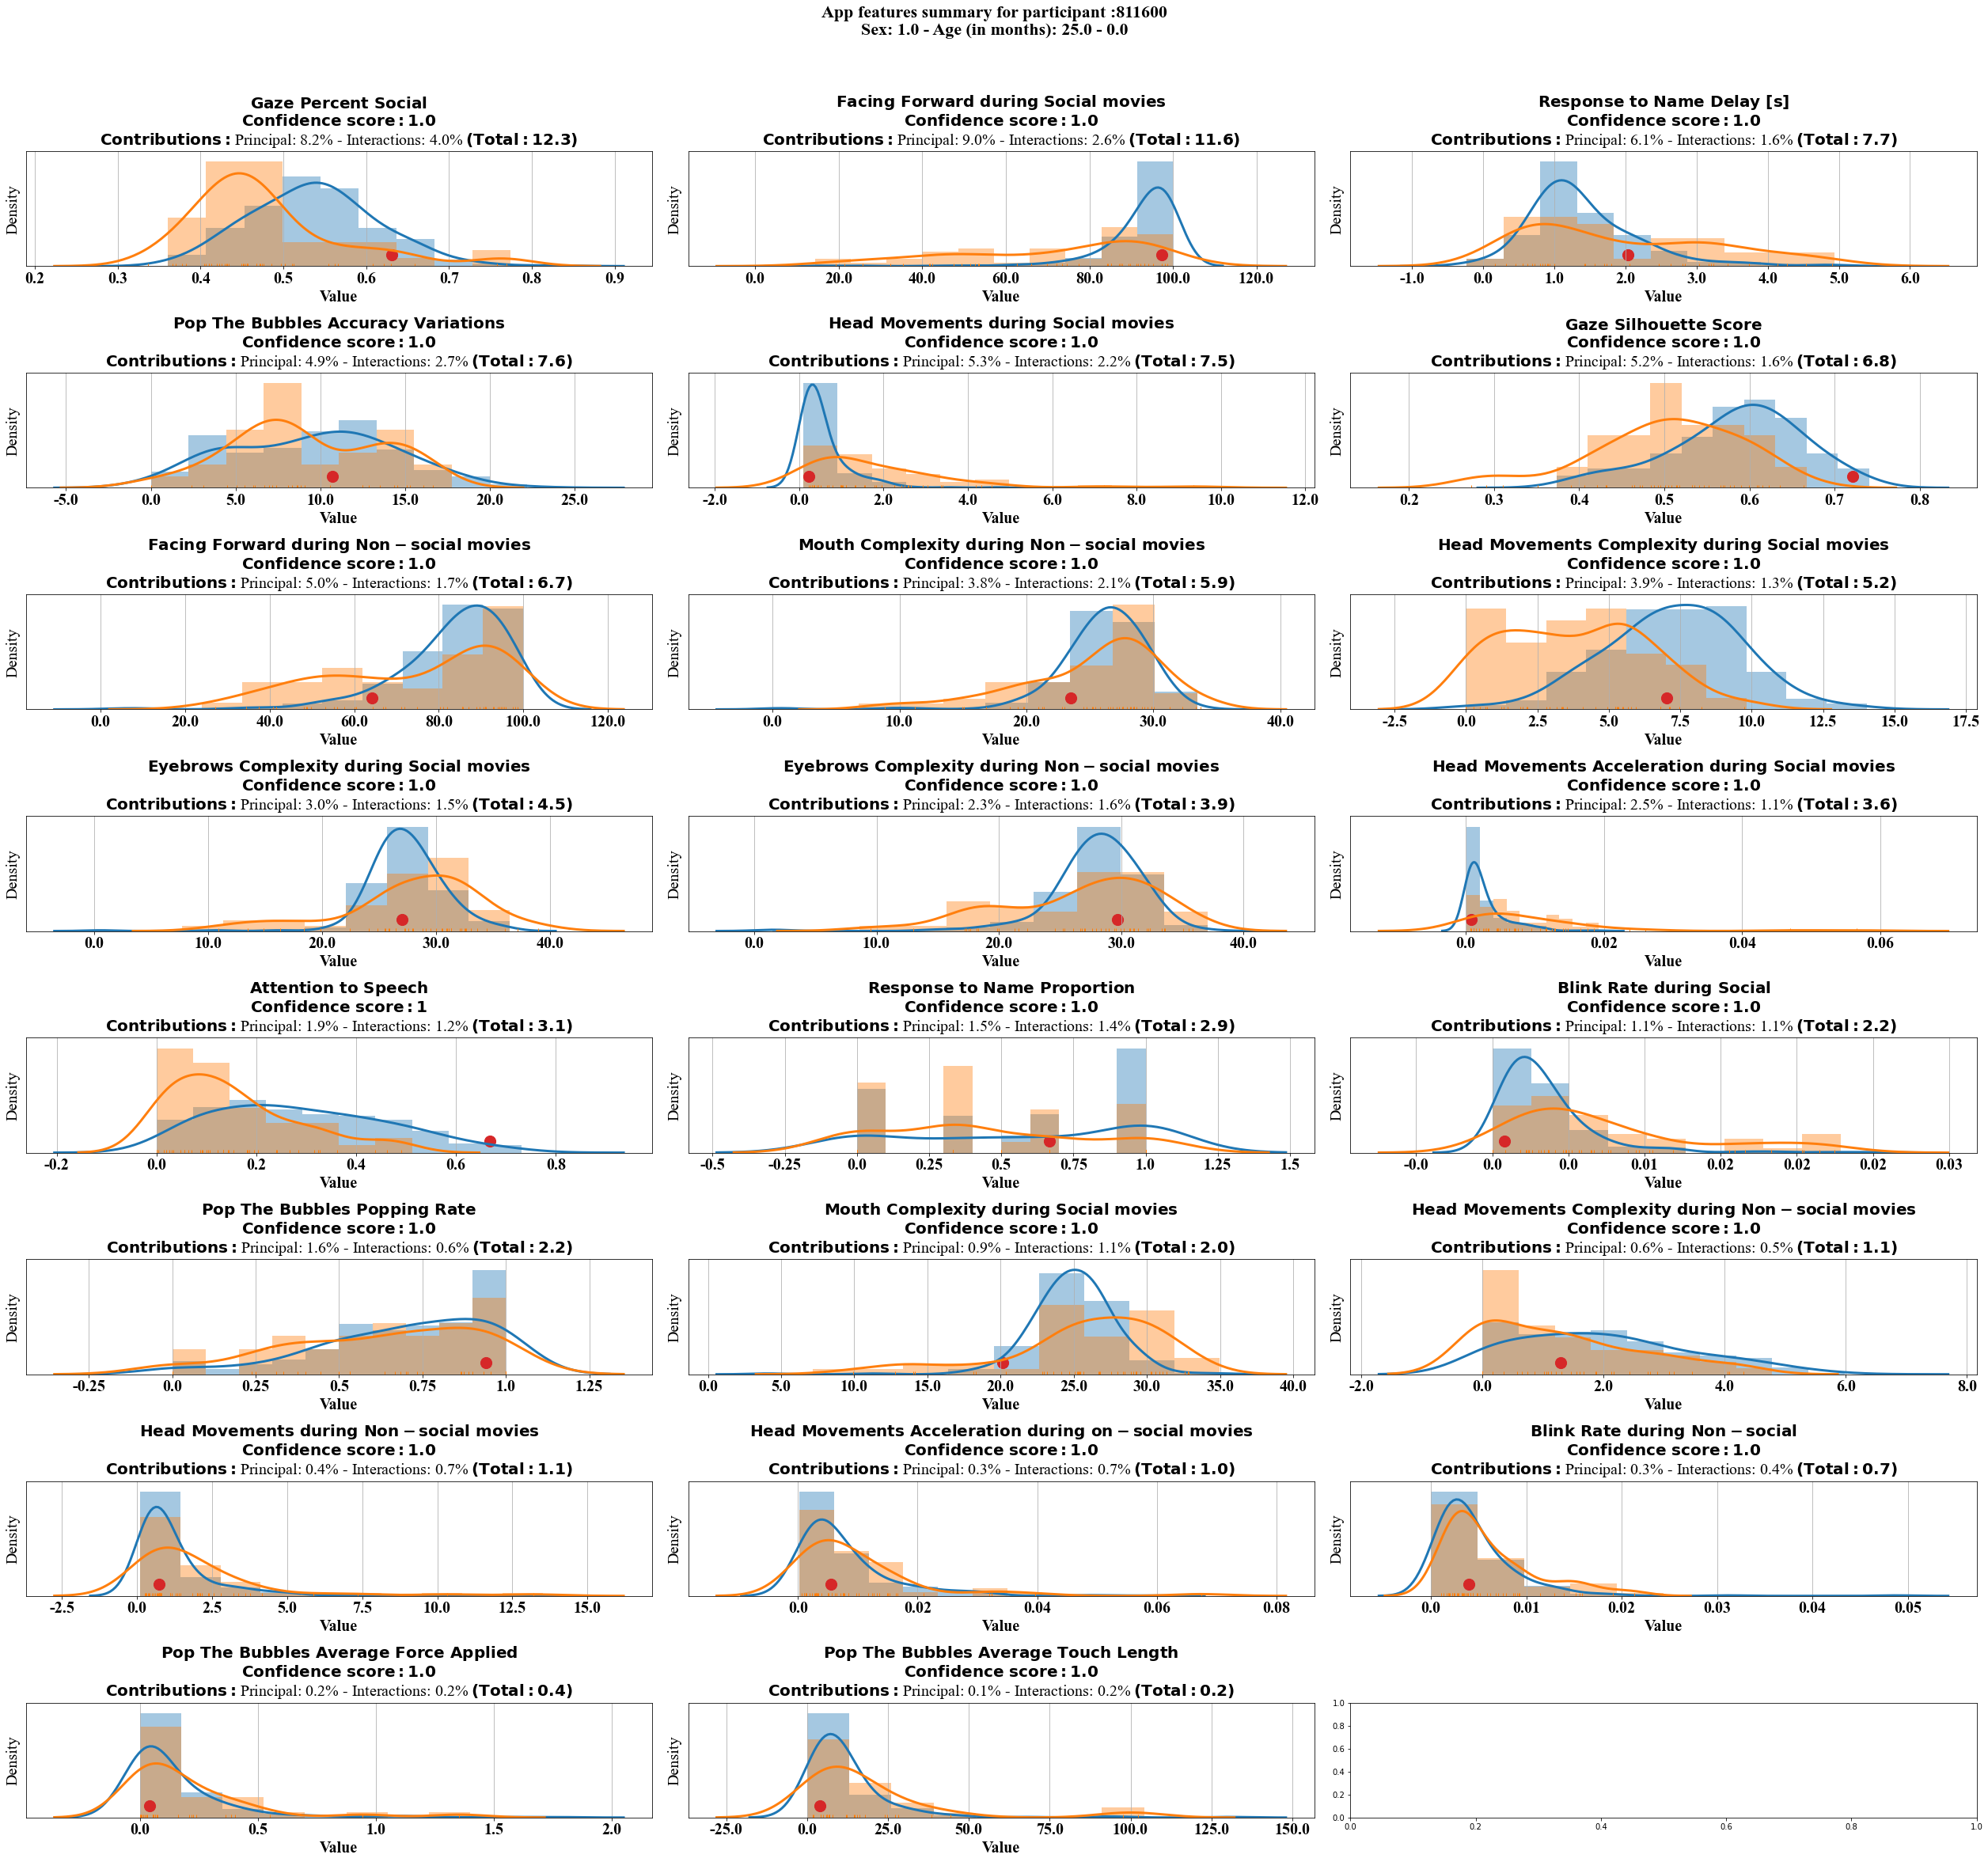

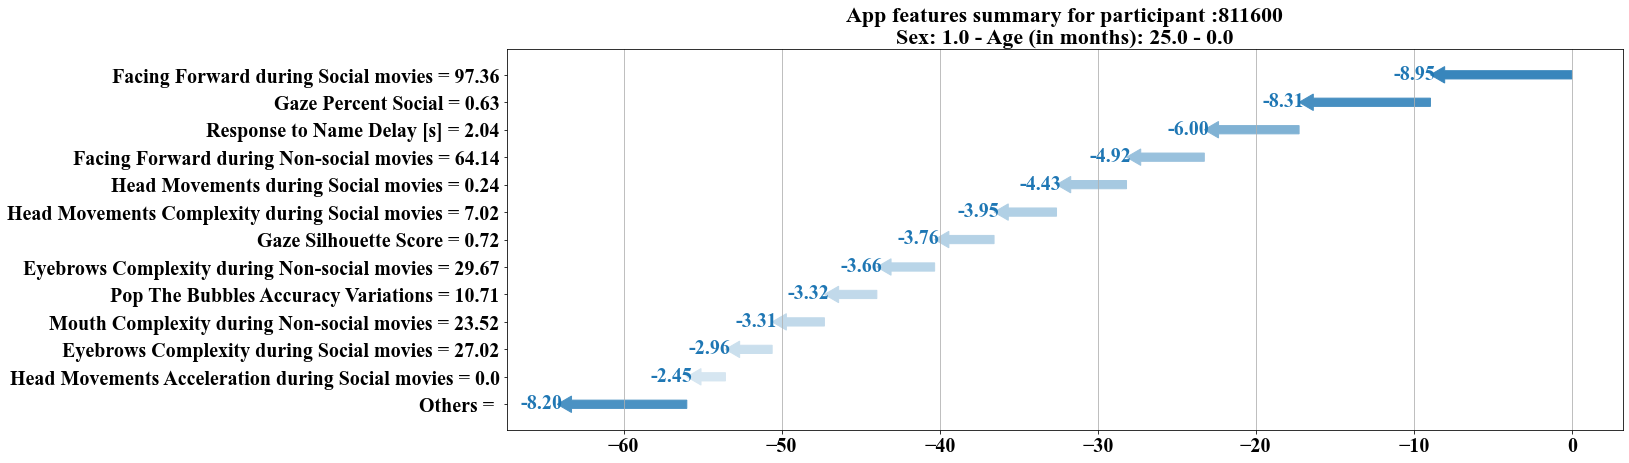

Facing Forward during Social movies: 1.00
Gaze Percent Social: 1.00
Response to Name Delay [s]: 1.00
Facing Forward during Non-social movies: 1.00
Head Movements during Social movies: 1.00
Head Movements Complexity during Social movies: 1.00
Gaze Silhouette Score: 1.00
Eyebrows Complexity during Non-social movies: 1.00
Pop The Bubbles Accuracy Variations: 1.00
Mouth Complexity during Non-social movies: 1.00
Eyebrows Complexity during Social movies: 1.00
Head Movements Acceleration during Social movies: 1.00



In [57]:
index_sample = 165
display(exp.dataset.df.iloc[index_sample:index_sample+1][['quality_score', 'conslusiveness_score']])

report_participant(exp, index_sample)

**Show hard to classiffy ASD without MCHAT**

quality_score  conslusiveness_score
47       0.939692                 0.466

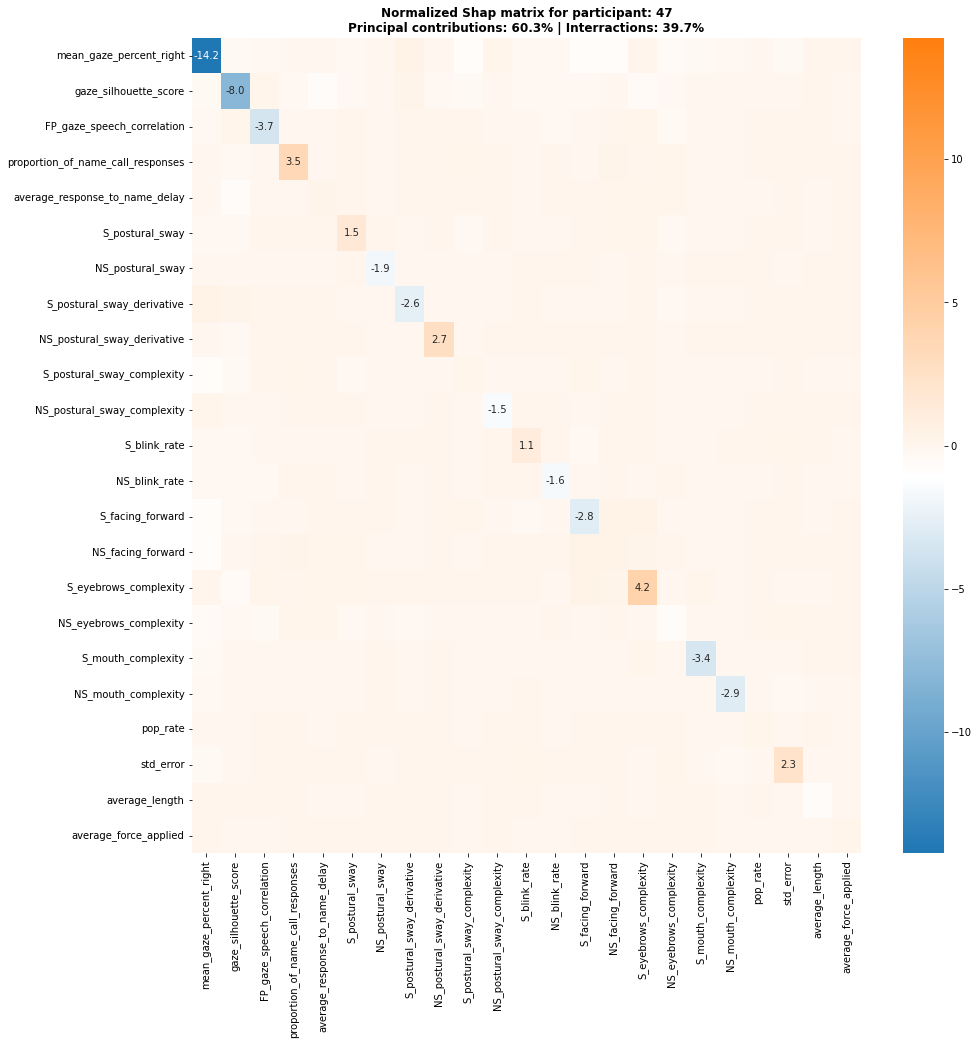

total       main interaction first_interaction          first_interaction_name
mean_gaze_percent_right            19.874328  14.225891    5.648437          0.741698               NS_facing_forward
gaze_silhouette_score              12.012329   8.037712    3.974617          0.644729  average_response_to_name_delay
S_eyebrows_complexity               6.383419   4.163296    2.220123          0.492046           gaze_silhouette_score
FP_gaze_speech_correlation           5.59398    3.66309     1.93089           0.38075          NS_eyebrows_complexity
S_facing_forward                    5.361275   2.810248    2.551027          0.728722         mean_gaze_percent_right
proportion_of_name_call_responses   4.628724   3.453411    1.175313          0.228747               NS_facing_forward
S_mouth_complexity                  4.476187   3.441516    1.034671          0.378511         mean_gaze_percent_right
S_postural_sway_derivative          4.183248   2.615621    1.567627          0.366668         mean_gaze_percent_right
NS_mouth_complexity                 3.961444   2.937095    1.024349          0.165582         mean_gaze_percent_right
std_error                           3.796272   2.258188    1.538084           0.40227         mean_gaze_percent_right
NS_postural_sway_derivative         3.650525   2.690129    0.960396          0.183504           gaze_silhouette_score
NS_eyebrows_complexity              3.373986   0.595386    2.778601           0.54062         mean_gaze_percent_right
S_postural_sway                     3.192298   1.514279    1.678019          0.315476         mean_gaze_percent_right
NS_facing_forward                   2.955602    0.41411    2.541493          0.741698         mean_gaze_percent_right
NS_blink_rate                       2.661102   1.593467    1.067634          0.217908           gaze_silhouette_score
NS_postural_sway                    2.520161   1.878973    0.641188          0.063854           gaze_silhouette_score
S_postural_sway_complexity          2.480489   0.210176    2.270313          0.710982         mean_gaze_percent_right
S_blink_rate                         2.38171   1.128267    1.253443          0.159031           gaze_silhouette_score
average_response_to_name_delay      2.329958   0.257083    2.072876          0.644729           gaze_silhouette_score
NS_postural_sway_complexity          2.09588   1.459667    0.636213          0.120562         mean_gaze_percent_right
average_length                      1.095639   0.601037    0.494602          0.084912             NS_mouth_complexity
average_force_applied               0.511221   0.191778    0.319443           0.06212                       std_error
pop_rate                            0.480223   0.126307    0.353916          0.090889      S_postural_sway_derivative
SUM                                      100  60.266726   39.733274

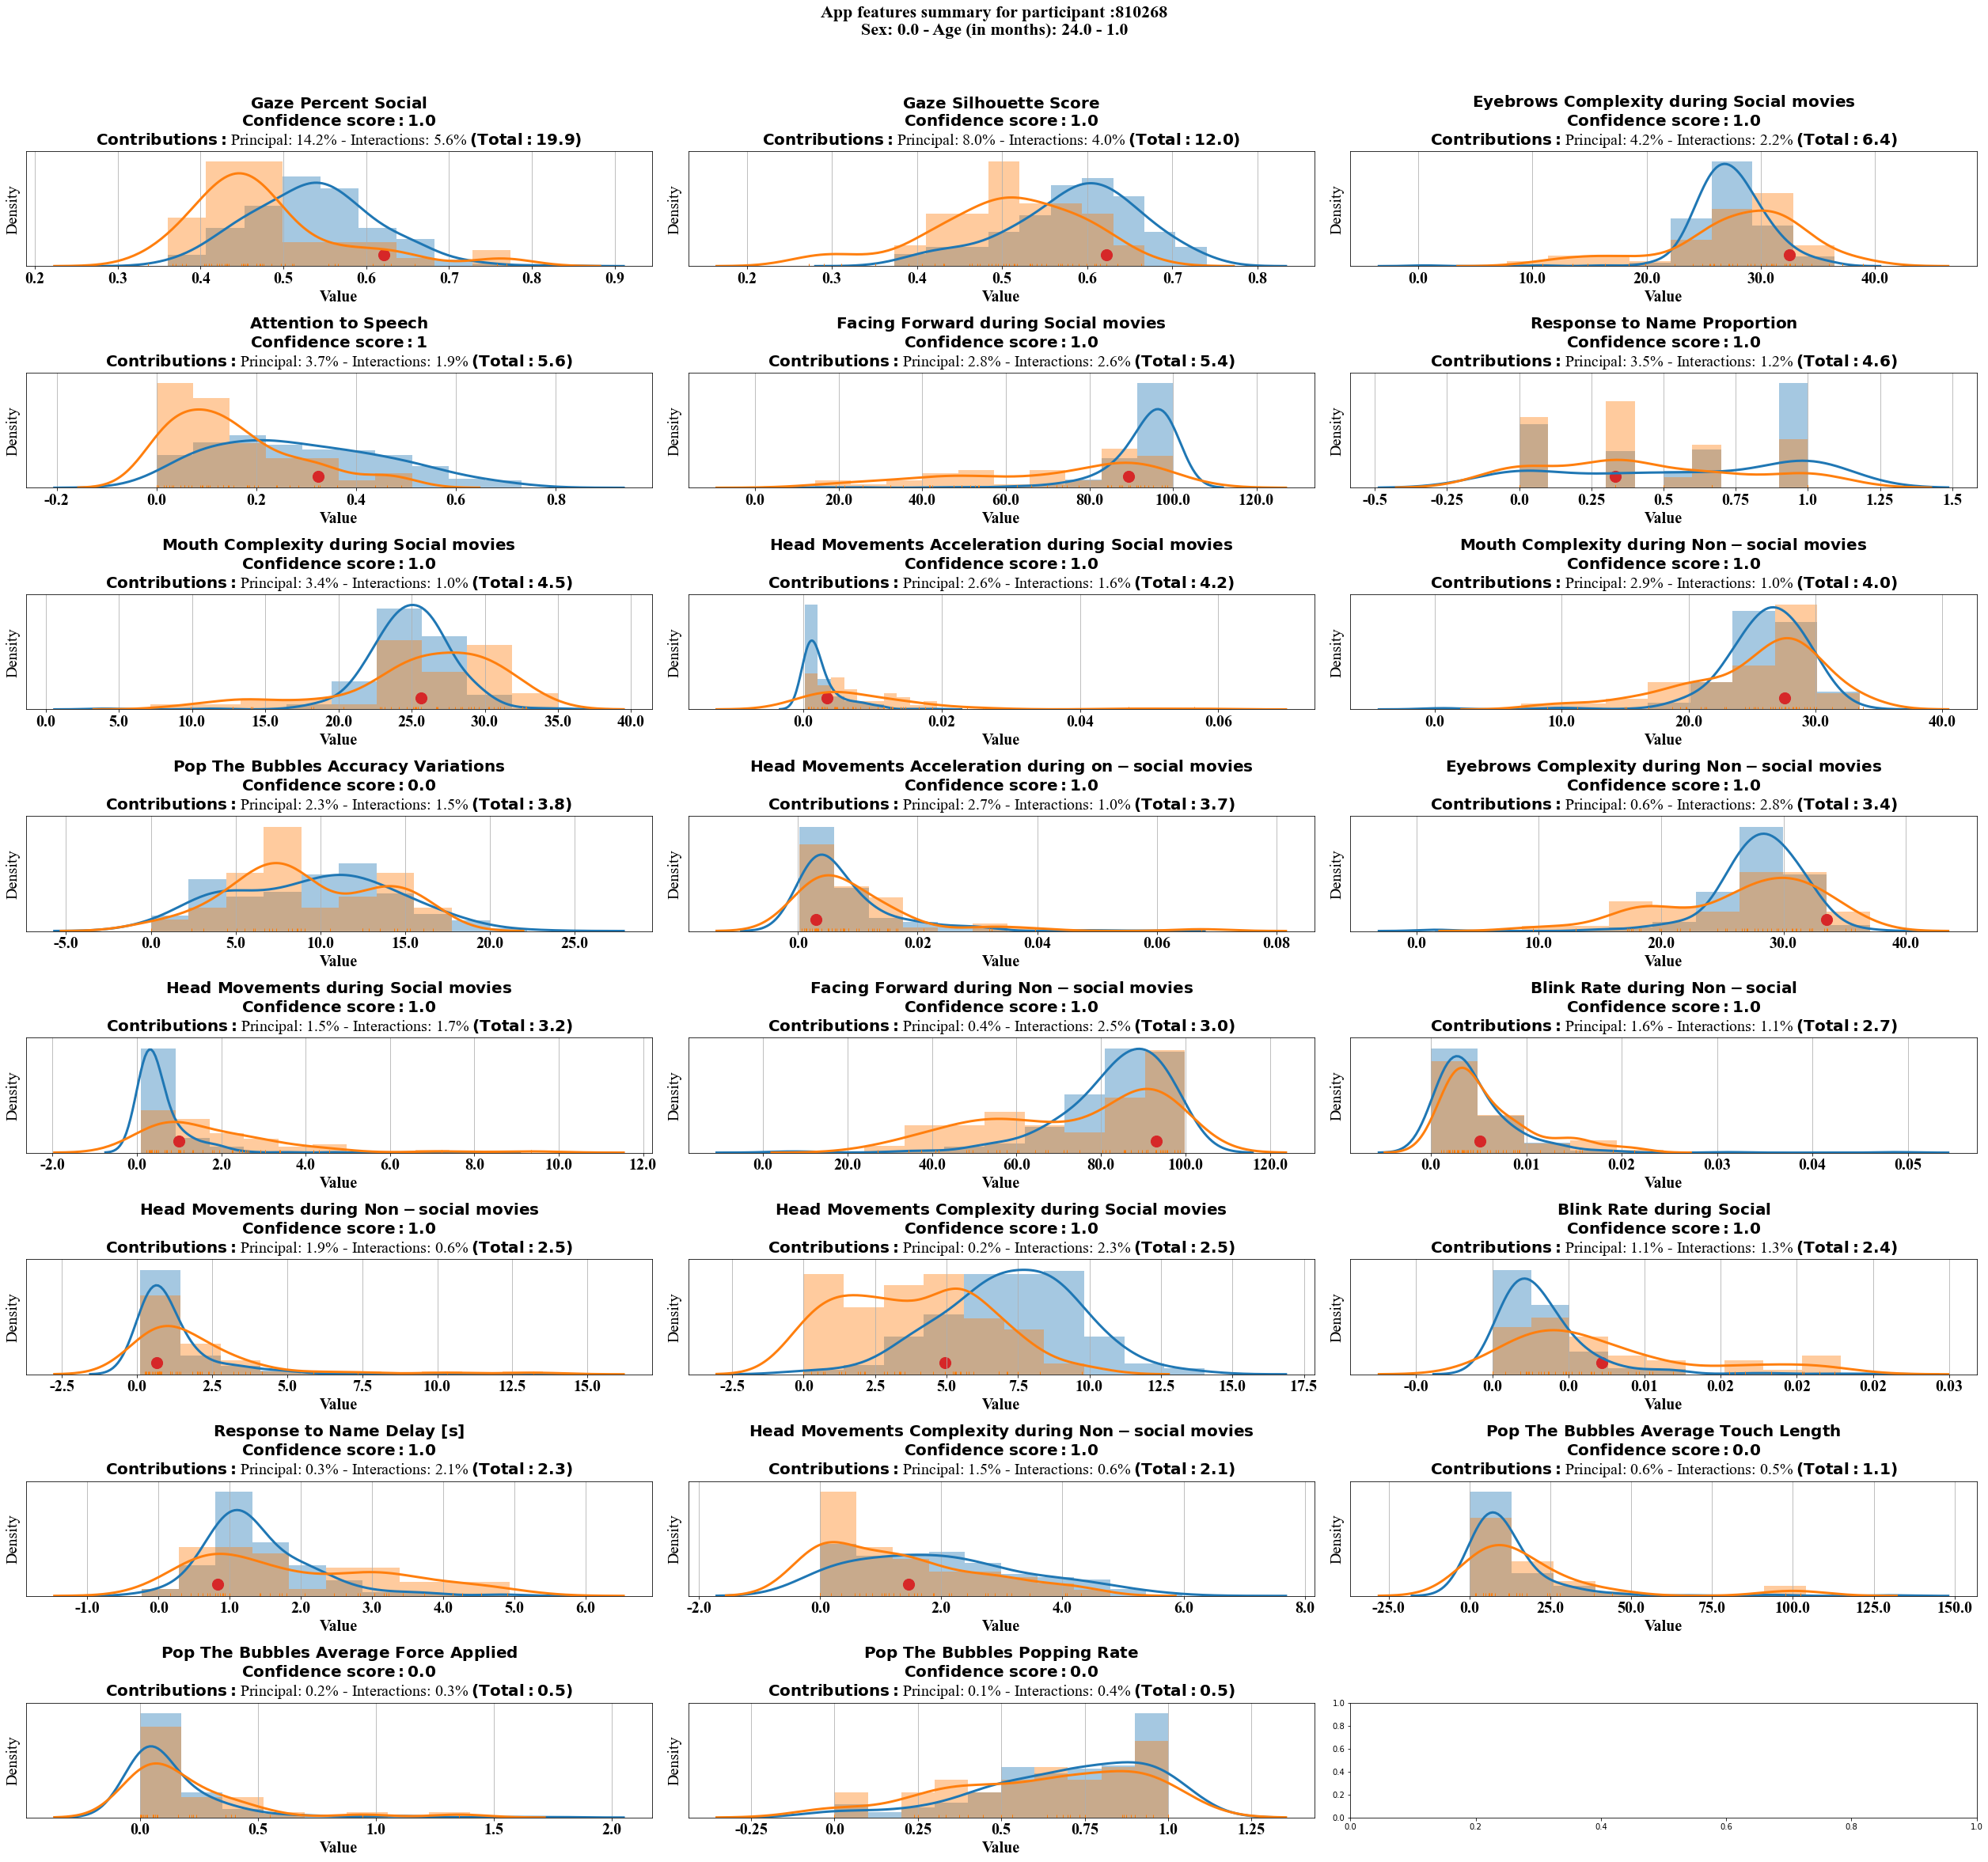

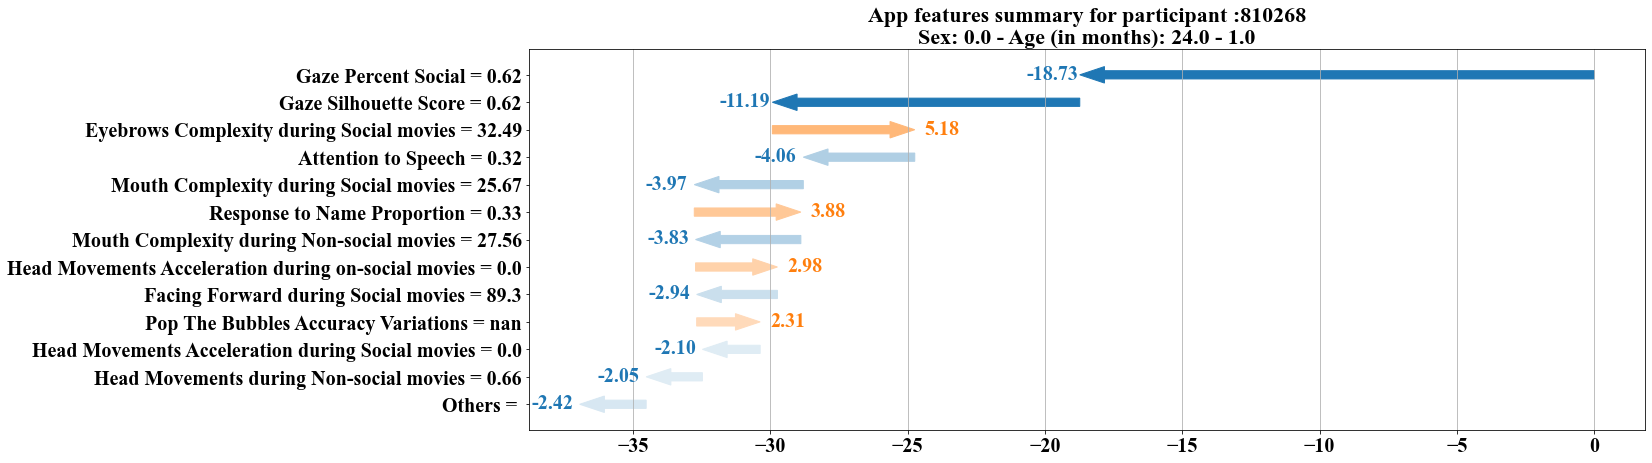

Gaze Percent Social: 1.00
Gaze Silhouette Score: 1.00
Eyebrows Complexity during Social movies: 1.00
Attention to Speech: 1.00
Mouth Complexity during Social movies: 1.00
Response to Name Proportion: 1.00
Mouth Complexity during Non-social movies: 1.00
Head Movements Acceleration during on-social movies: 1.00
Facing Forward during Social movies: 1.00
Pop The Bubbles Accuracy Variations: 0.00
Head Movements Acceleration during Social movies: 1.00
Head Movements during Non-social movies: 1.00



In [58]:
index_sample = 47
display(exp.dataset.df.iloc[index_sample:index_sample+1][['quality_score', 'conslusiveness_score']])

report_participant(exp, index_sample)

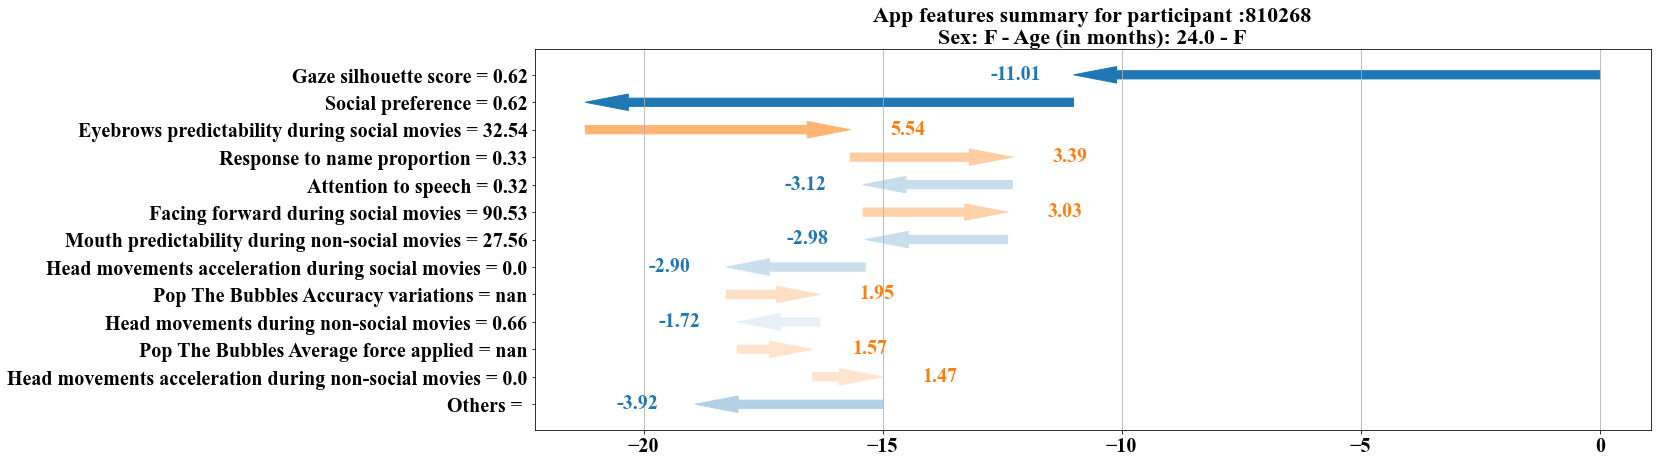

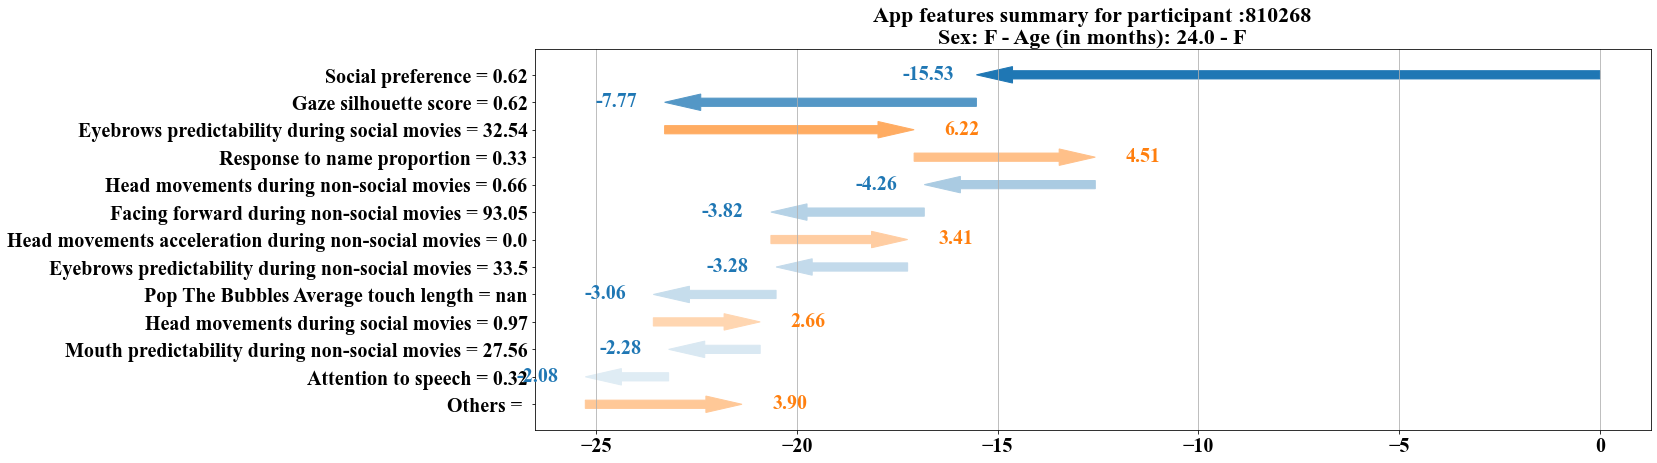

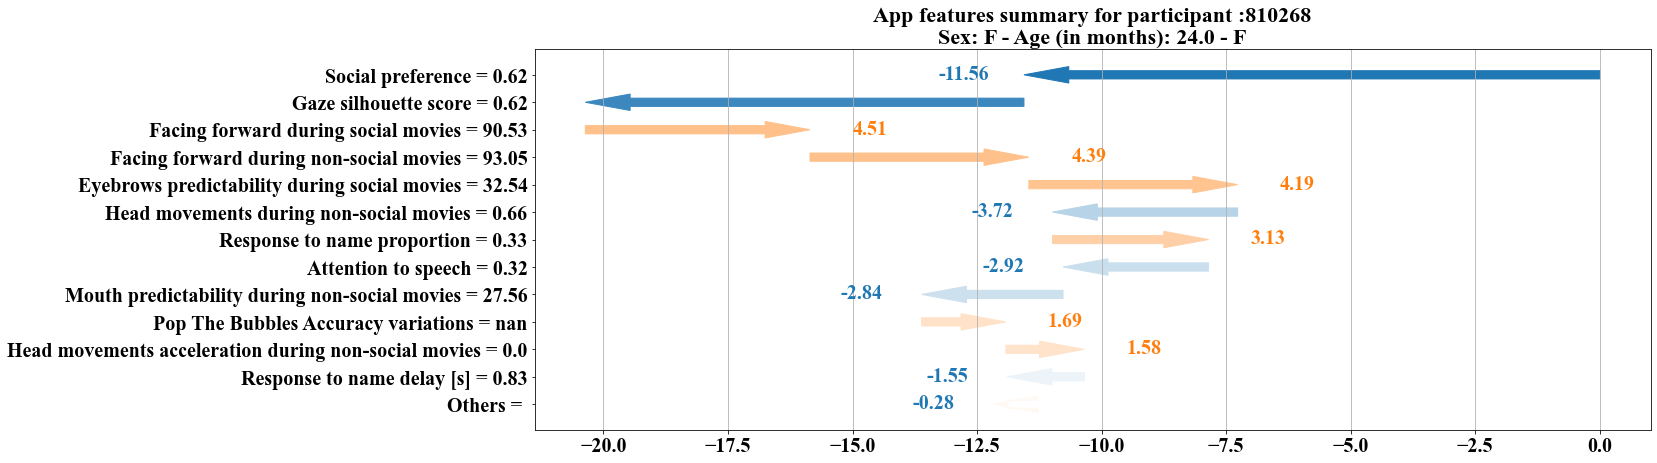

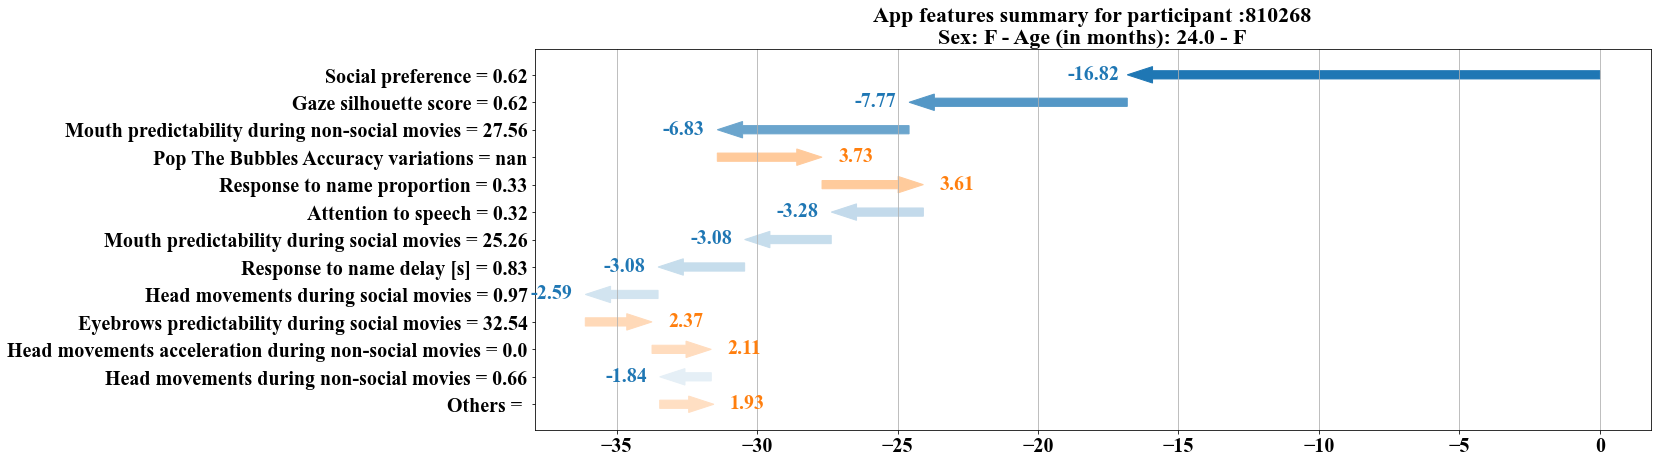

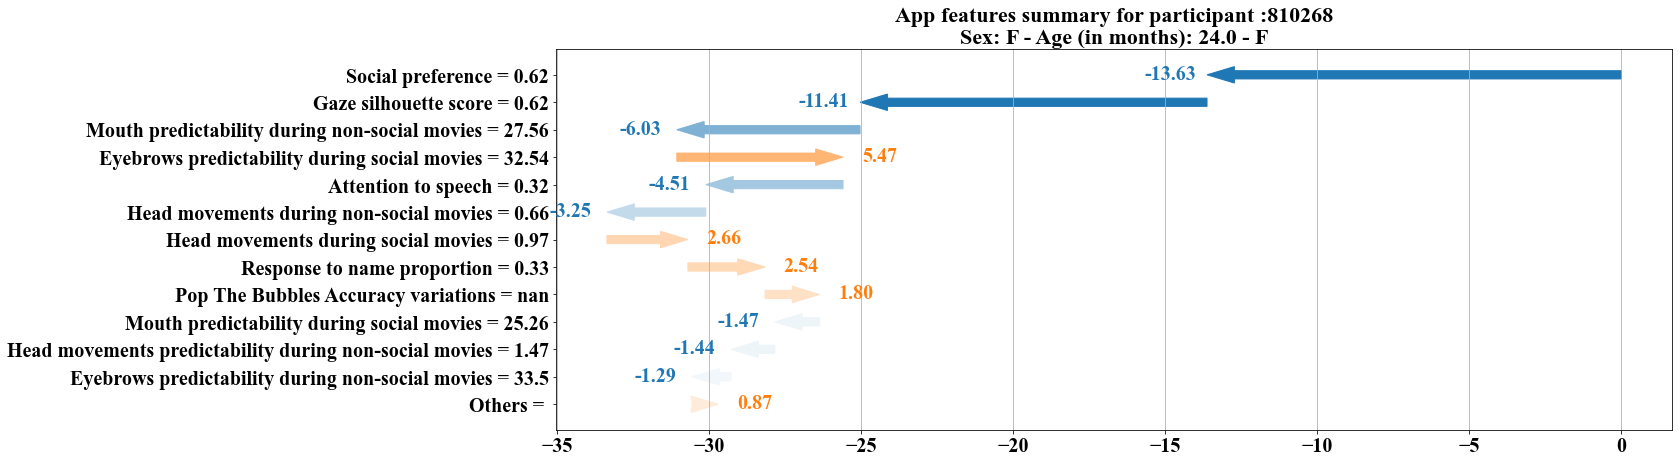

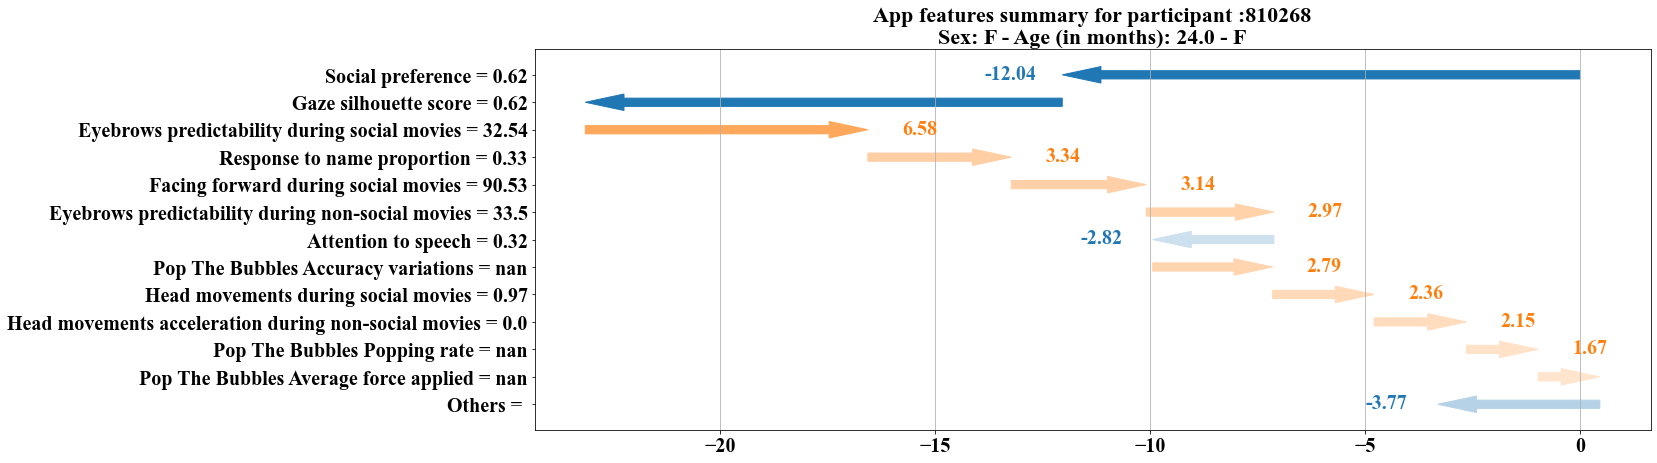

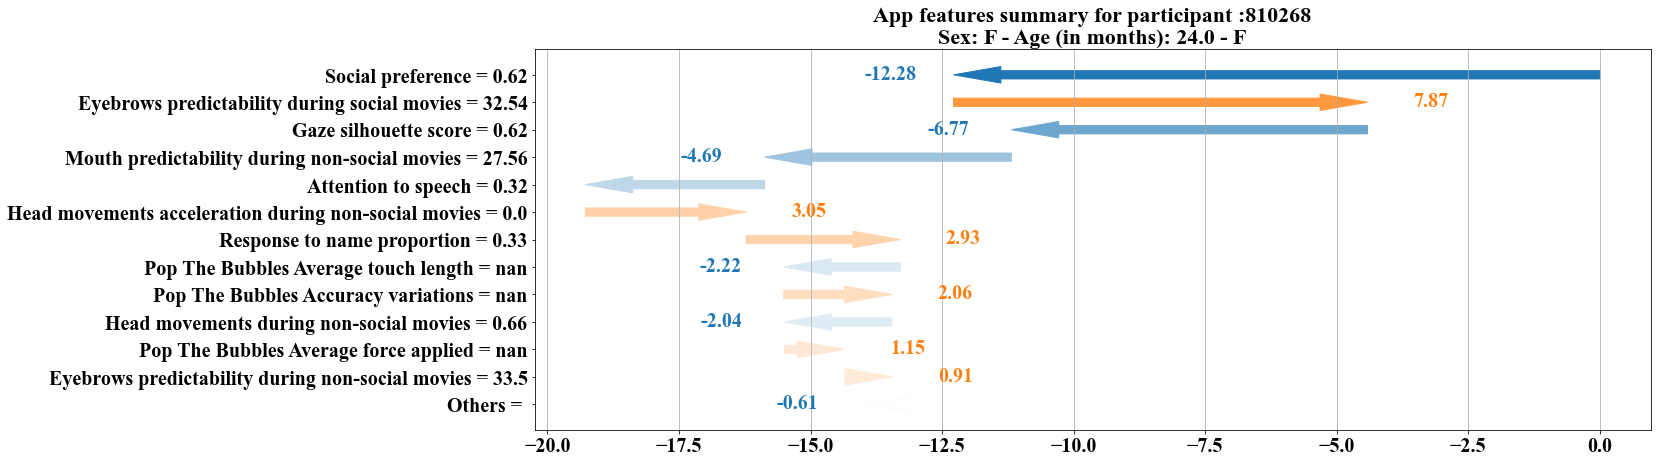

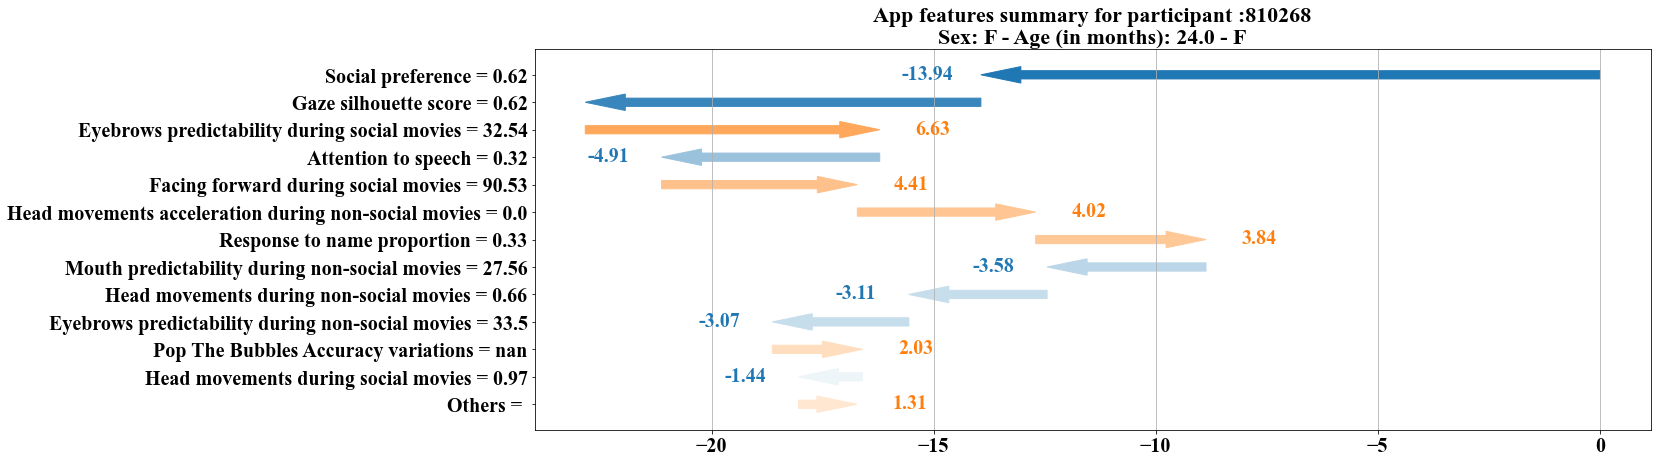

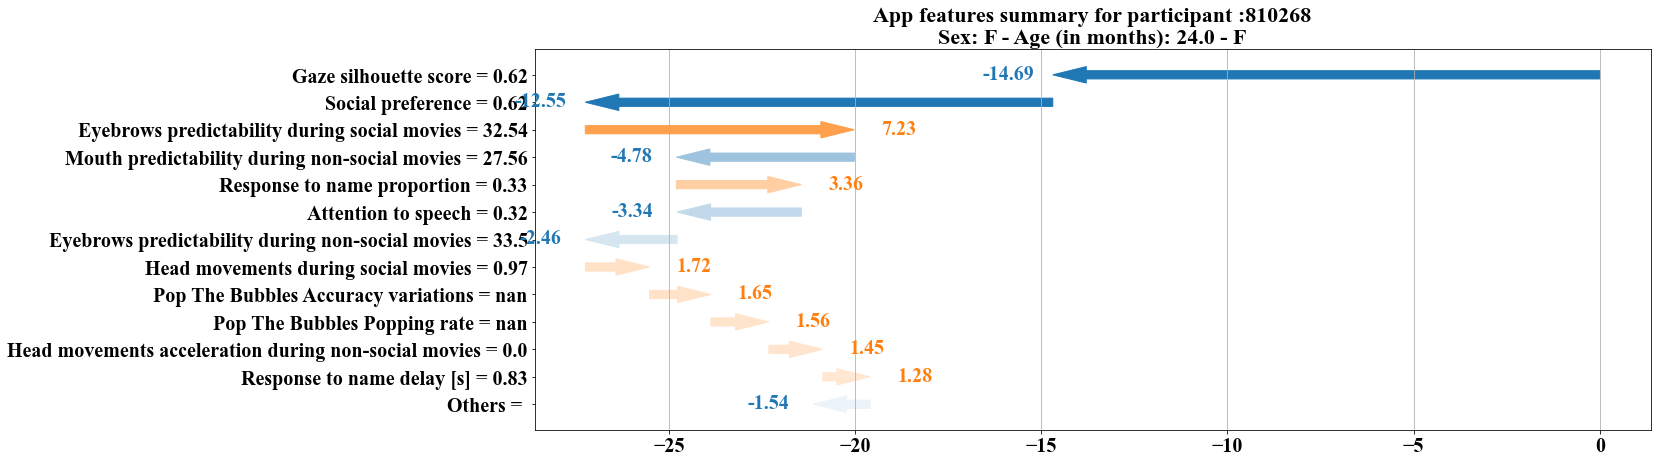

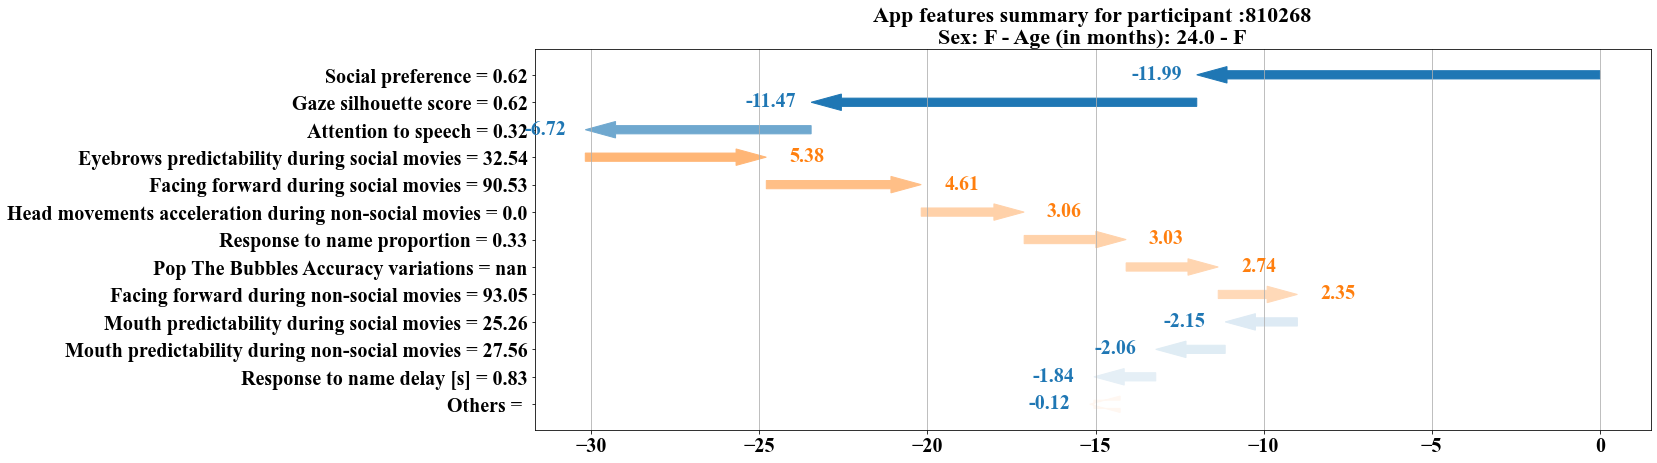

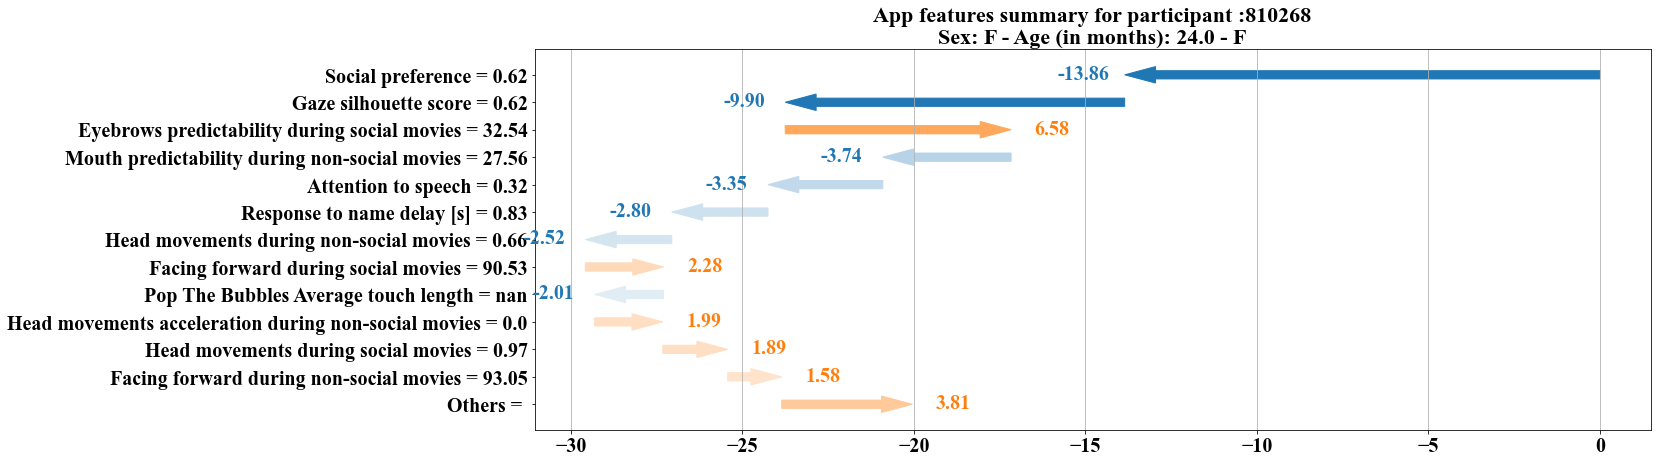

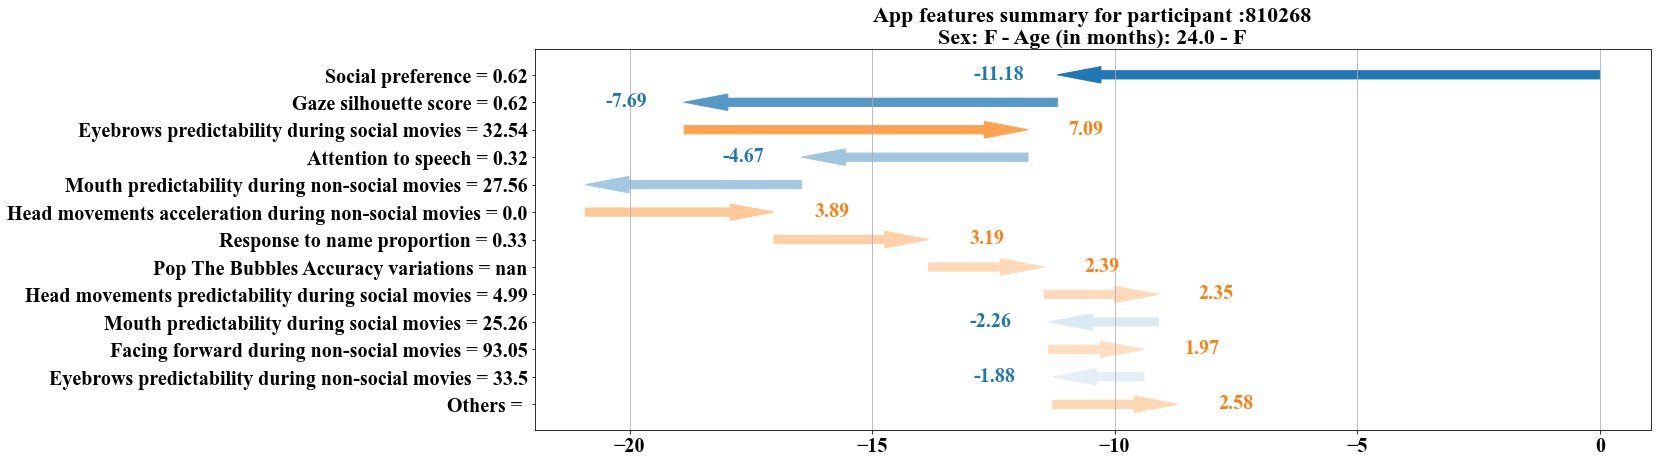

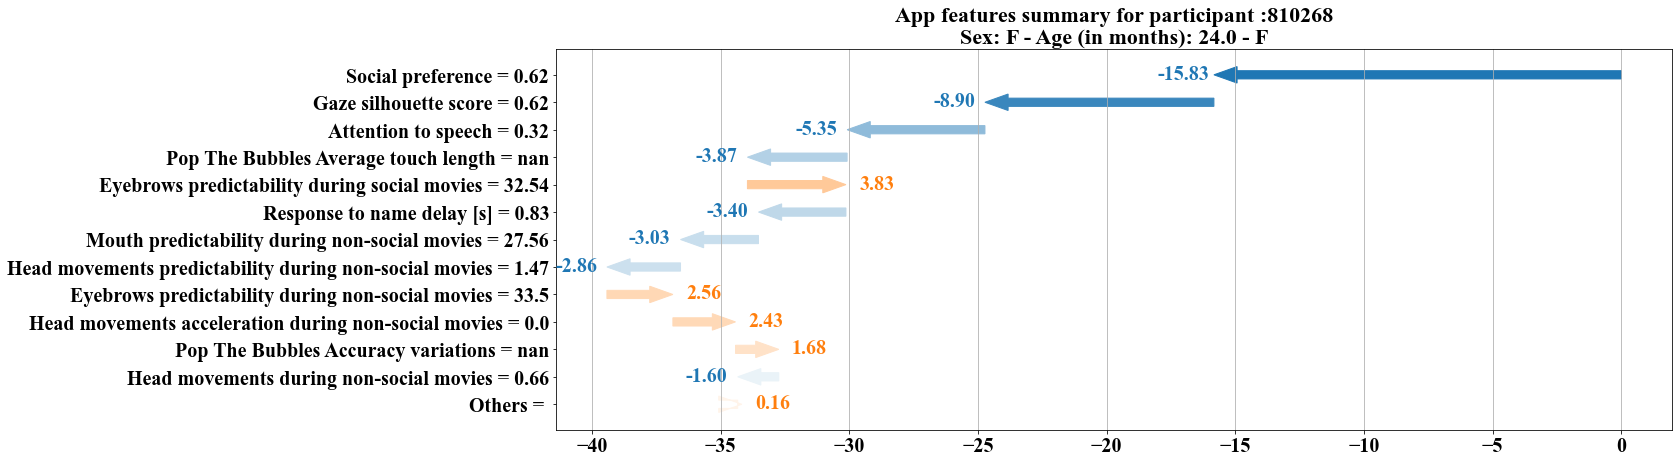

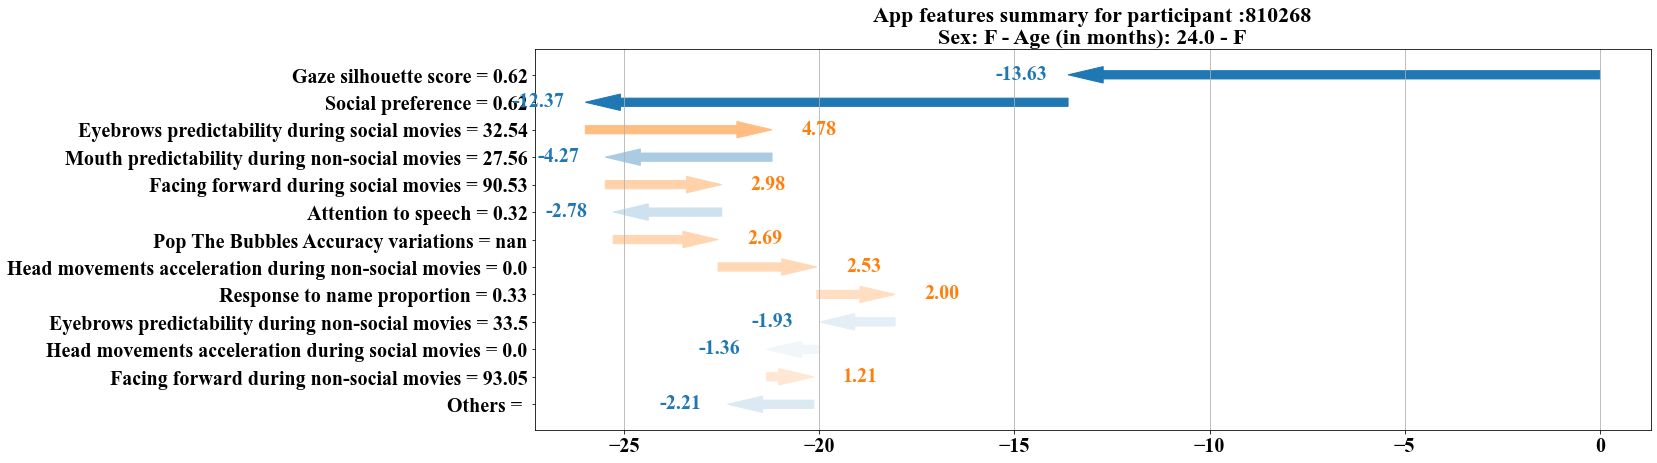

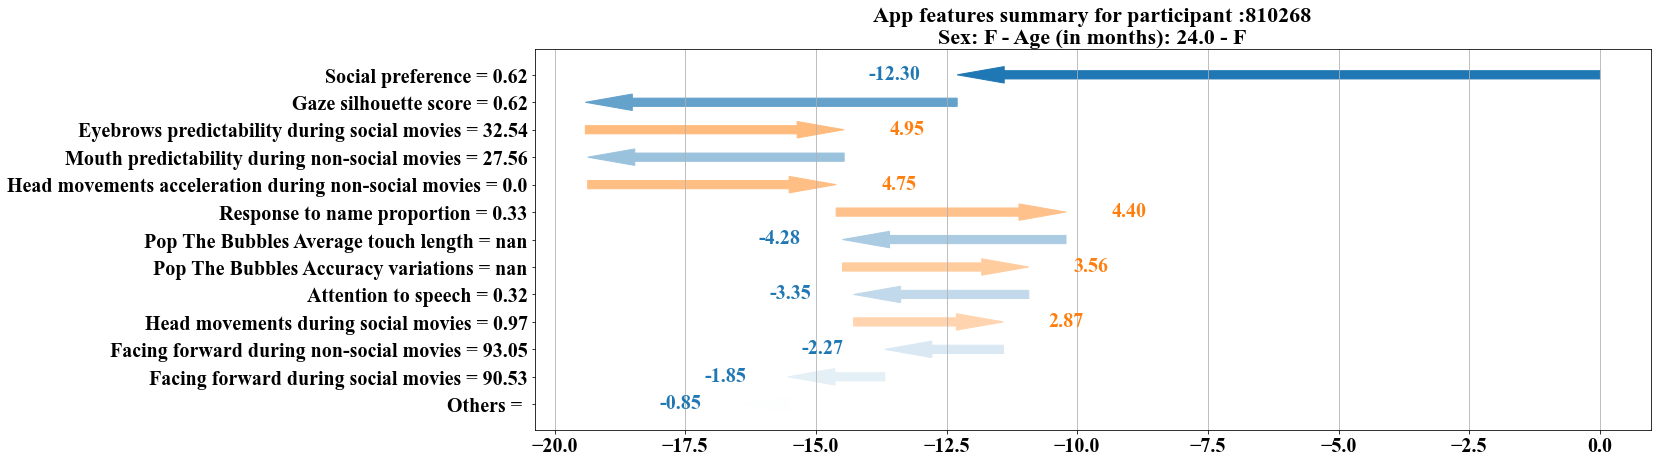

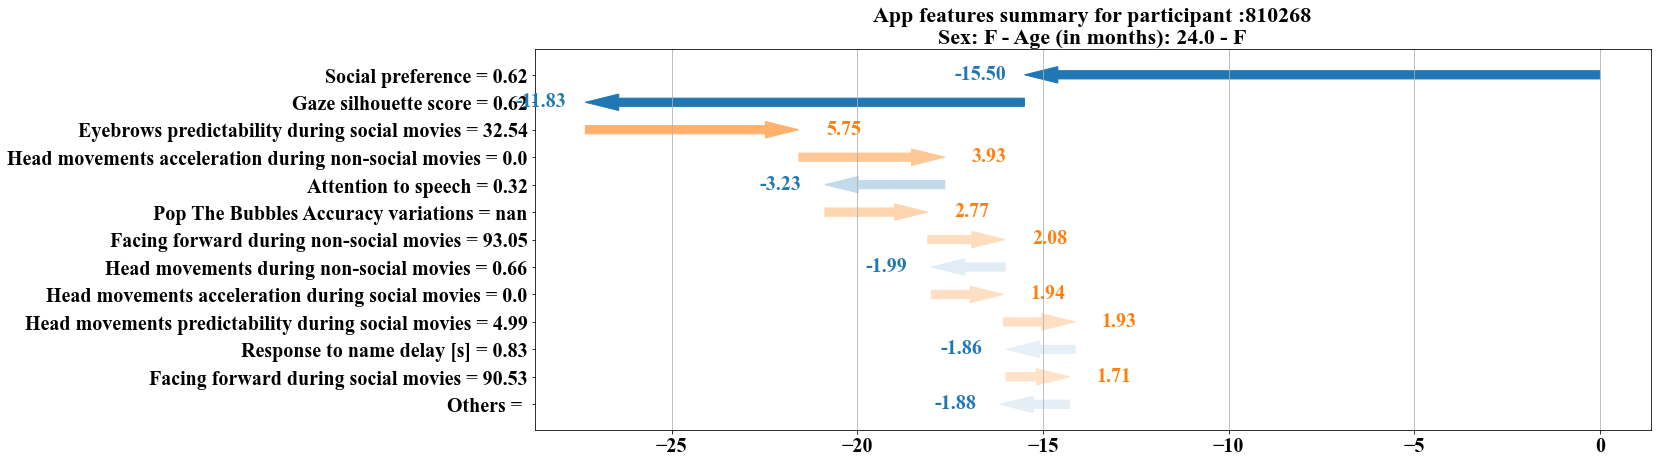

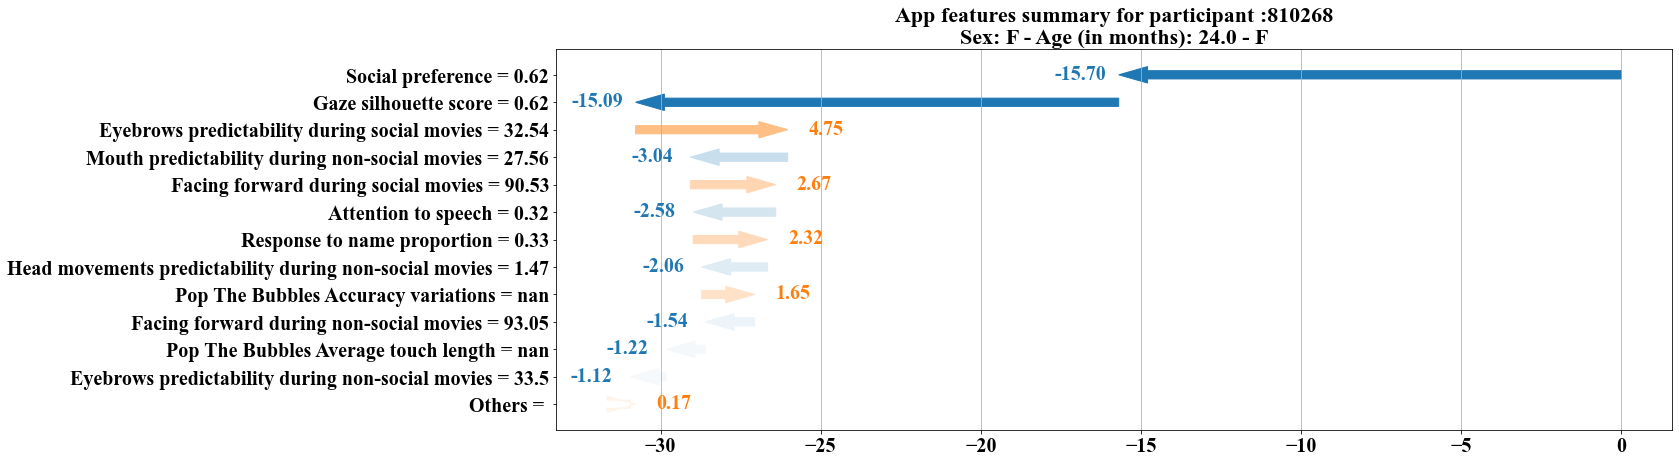

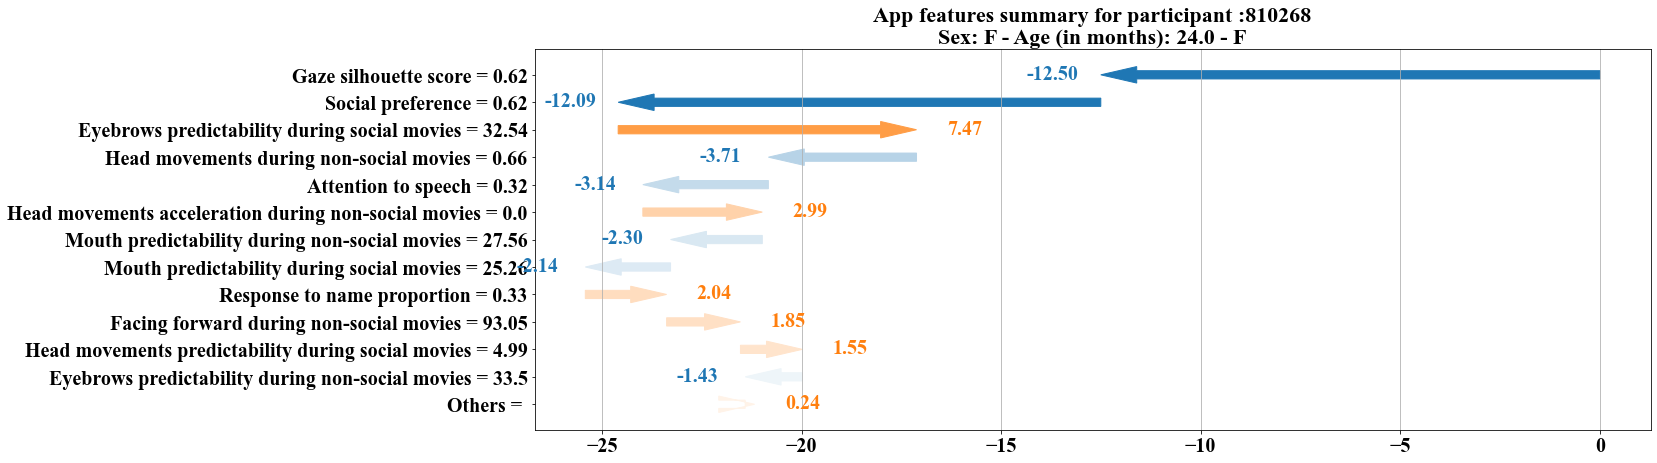

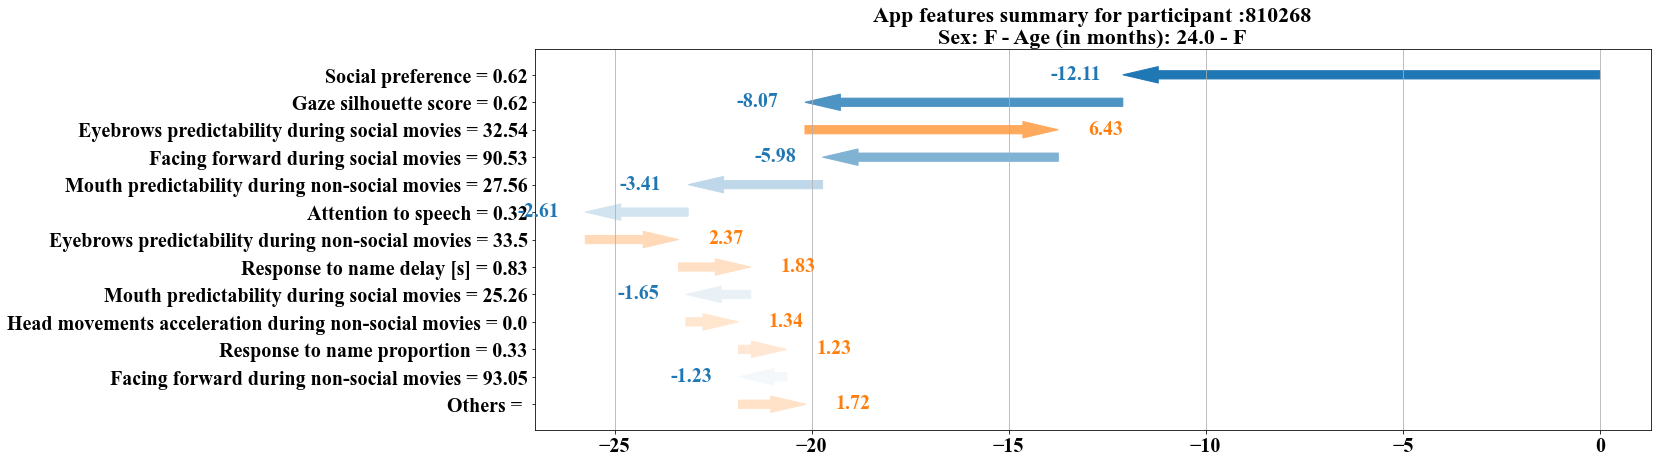

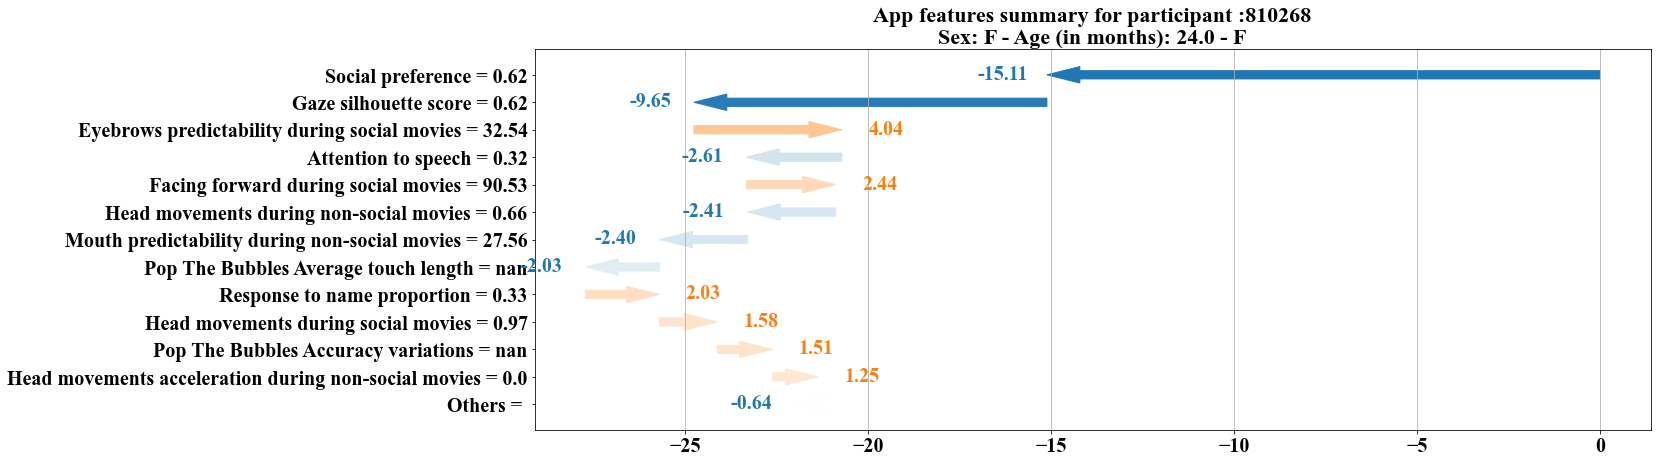

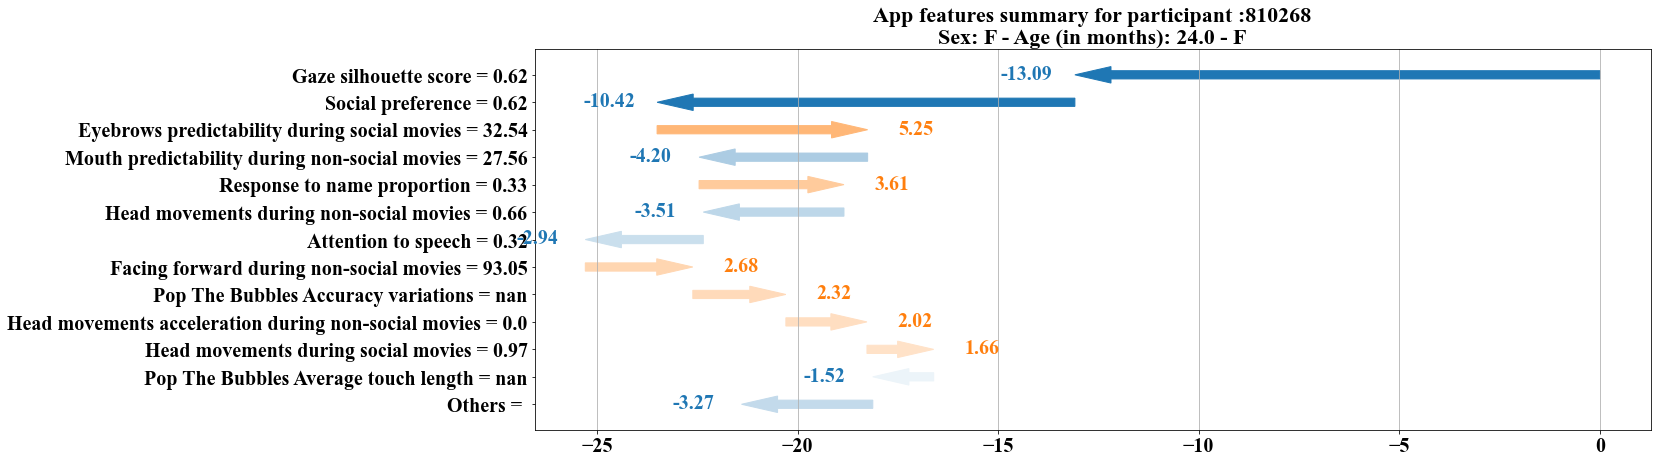

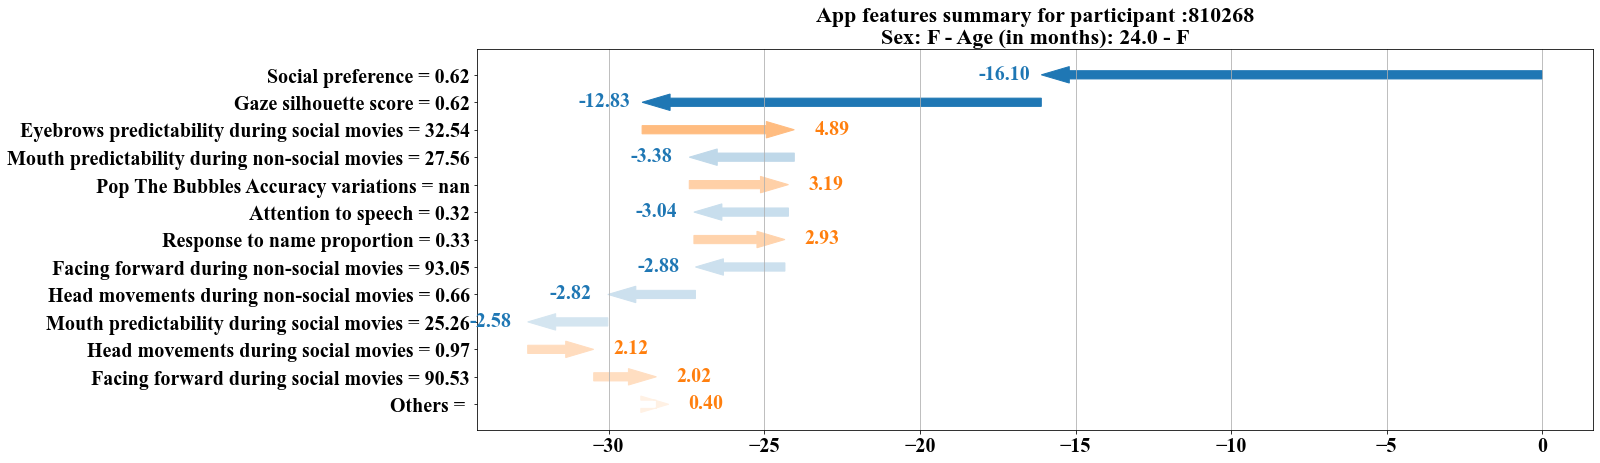

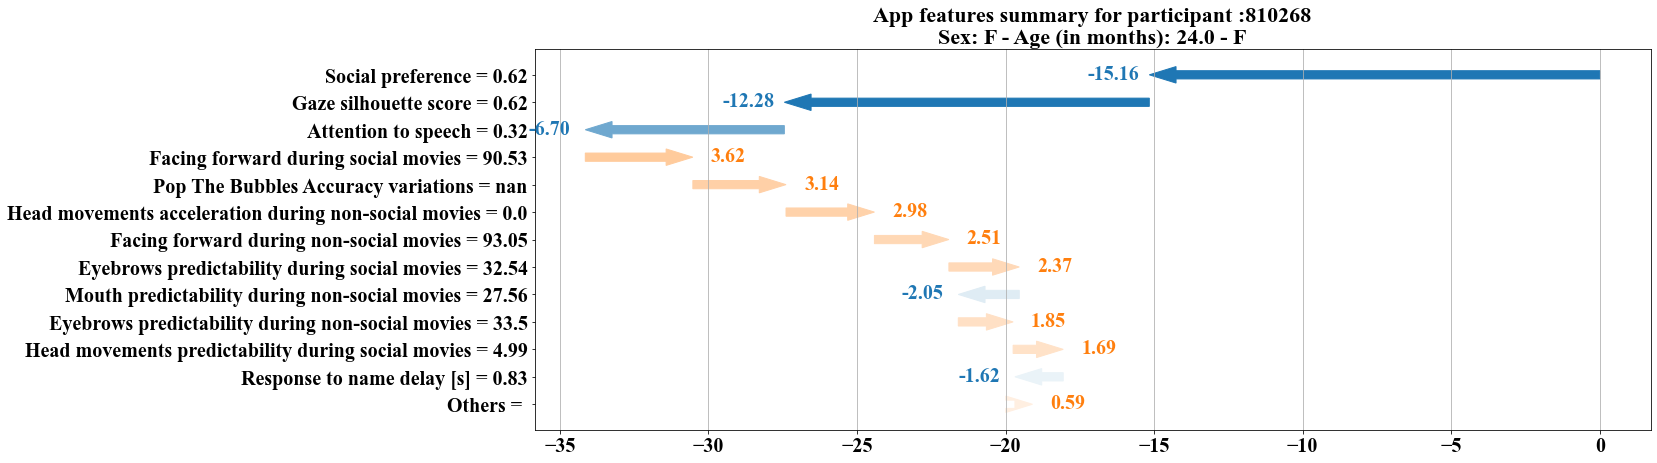

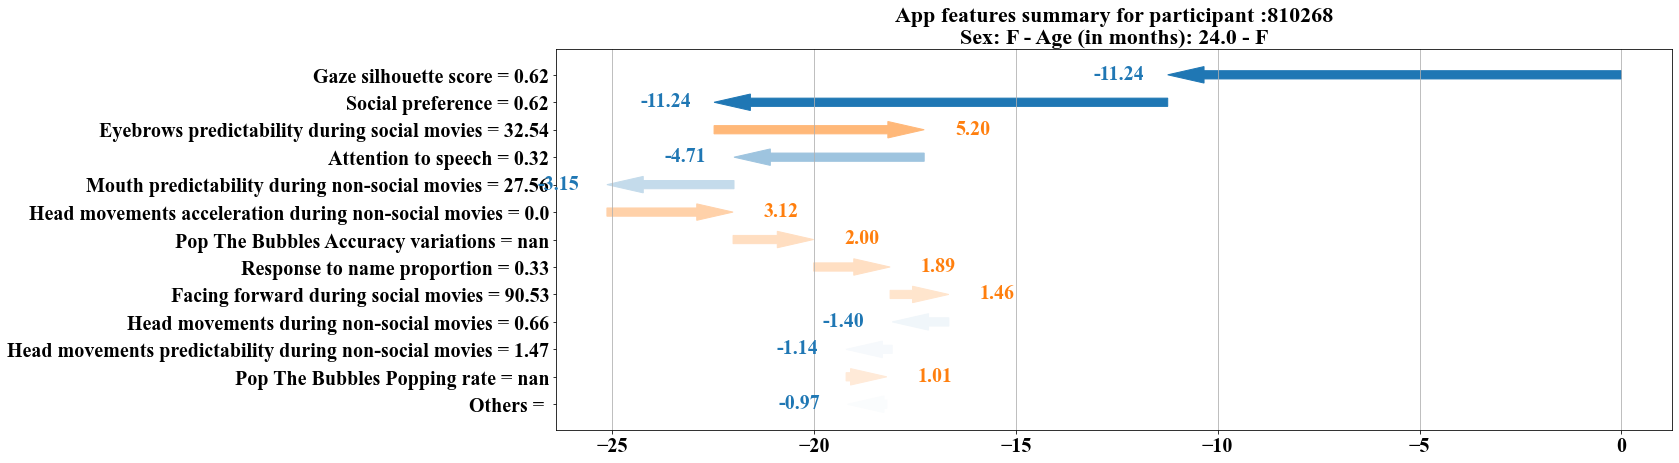

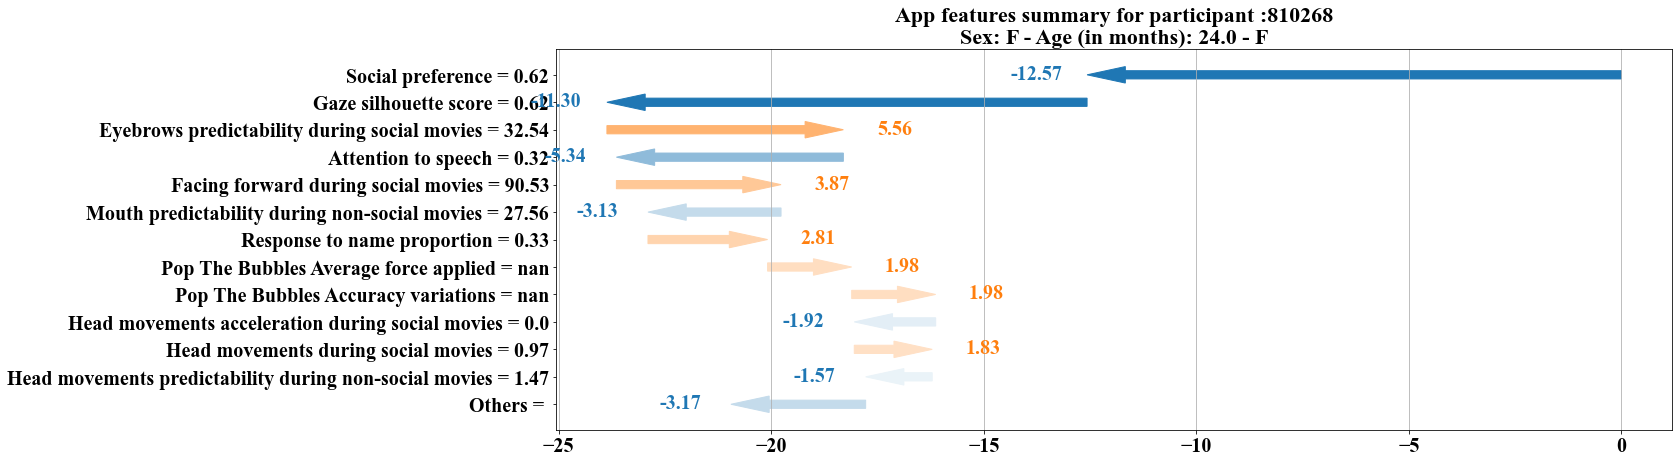

In [62]:
for i in range(25): # Draw a random smaple and plot the shap matrix
    matrix_shap = shap_interactions_normalized[i][index_sample]*100

    waterfall_plot(exp, matrix_shap, index_sample)

**Show False Positive**

In [81]:
exp.predictions_df[exp.predictions_df['pred_class']=='FN']

mean_gaze_percent_right  gaze_silhouette_score  FP_gaze_speech_correlation  proportion_of_name_call_responses  average_response_to_name_delay  S_postural_sway  NS_postural_sway  S_postural_sway_derivative  NS_postural_sway_derivative  S_postural_sway_complexity  NS_postural_sway_complexity  S_facing_forward  NS_facing_forward  S_eyebrows_complexity  NS_eyebrows_complexity  S_mouth_complexity  NS_mouth_complexity  pop_rate  std_error  average_length  average_force_applied  y_true    y_pred  TN  TP  FP  FN pred_class  conslusiveness_score
3                   0.510189               0.608424                    0.056406                           0.666667                        2.469133         1.328129          2.397114                    0.004554                     0.012627                    3.651270                     0.647567         82.993961          67.376848              28.541997               21.578304           26.958703            19.827632       NaN        NaN             NaN                    NaN     1.0  0.005182   0   0   0   1         FN                  0.02
10                  0.370476               0.513576                    0.106330                           1.000000                        0.722944         0.288321          0.278590                    0.001879                     0.001312                    8.585445                     2.887158         91.644199          92.912484              28.132391               29.459527           25.377356            25.801698       NaN        NaN             NaN                    NaN     1.0  0.000305   0   0   0   1         FN                  0.00
35                  0.452378               0.517506                    0.055674                           0.666667                        0.550550         2.171059          0.485643                    0.008712                     0.003309                    6.807071                     1.132027         80.404082          85.715025              20.855985               29.562172           19.196737            24.471573  0.533333   8.077437       12.326764               0.064923     1.0  0.030705   0   0   0   1         FN                  0.98
227                 0.561774               0.576836                    0.142624                           0.333333                        0.867533         0.376969          1.441525                    0.001139                     0.009709                    6.695202                     2.168086         94.054954          94.365692              28.029841               30.968278           27.747488            29.323335       NaN        NaN             NaN                    NaN     1.0  0.000572   0   0   0   1         FN                  0.02
272                 0.501582               0.599296                    0.461882                           0.000000                             NaN         0.562841          1.392681                    0.003384                     0.007153                    7.079523                     0.858497         96.946706          82.046443              30.720274               27.628416           25.560943            28.509753  0.750000  12.478407        6.014059               0.071955     1.0  0.000098   0   0   0   1         FN                  0.00
336                 0.607484               0.390397                    0.063776                           0.000000                             NaN         0.785228          0.550685                    0.003690                     0.003032                    8.316039                     4.073000         90.355307          95.510094              31.199868               32.216073           24.607172            24.766872  0.250000  16.662007       24.815455               0.008114     1.0  0.029866   0   0   0   1         FN                  0.14
375                 0.425809               0.551651                         NaN                           0.666667                        0.316983         0.232464      

quality_score  conslusiveness_score
107       0.956546                 0.939

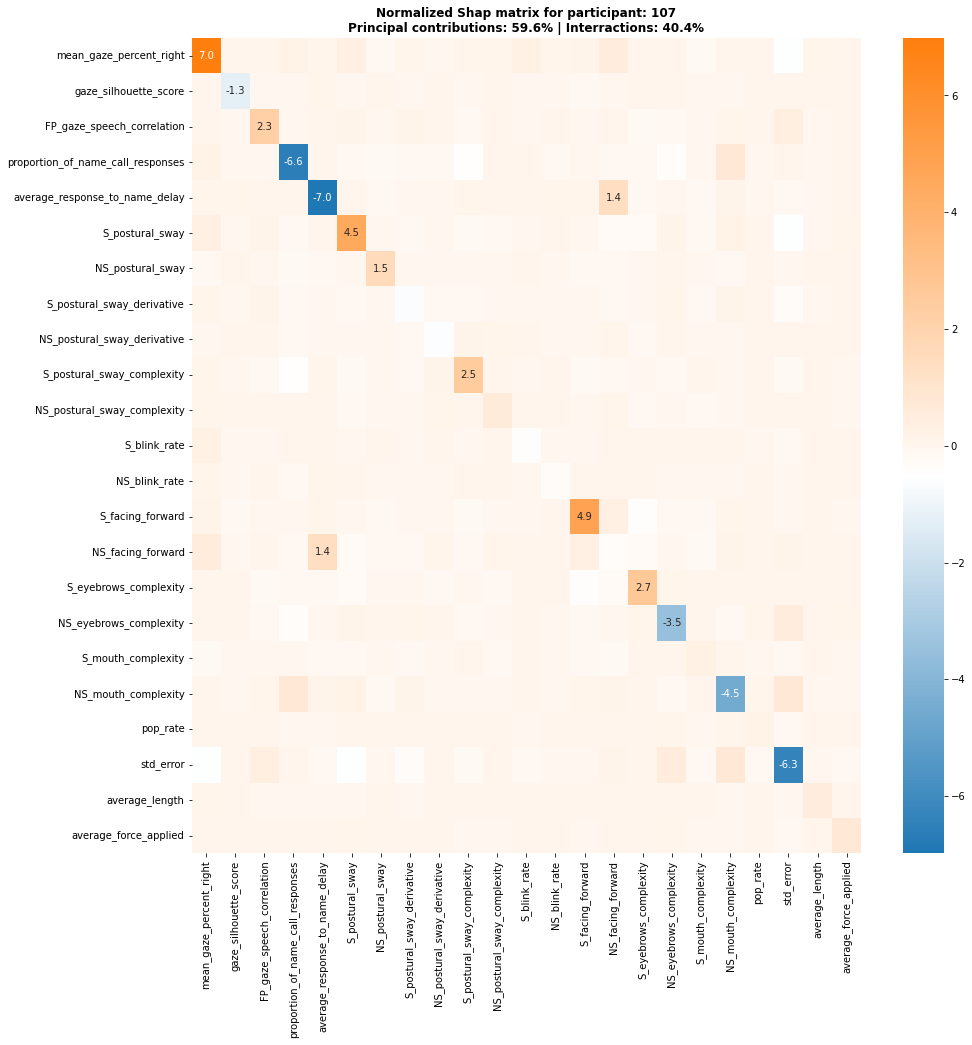

total       main interaction first_interaction             first_interaction_name
std_error                          10.727602   6.346177    4.381425          0.795765                NS_mouth_complexity
mean_gaze_percent_right            10.174738   6.967119    3.207619          0.590441                  NS_facing_forward
average_response_to_name_delay      9.671538   6.981224    2.690314          1.388065                  NS_facing_forward
proportion_of_name_call_responses   9.532393   6.622714    2.909679          0.718975                NS_mouth_complexity
NS_mouth_complexity                 7.278697   4.533576     2.74512          0.795765                          std_error
S_postural_sway                     7.242679   4.486241    2.756439          0.553791                          std_error
S_facing_forward                    6.673392   4.866994    1.806398          0.391195              S_eyebrows_complexity
NS_eyebrows_complexity              5.483927   3.522291    1.961636          0.585122                          std_error
NS_facing_forward                   4.424551   0.359438    4.065113          1.388065     average_response_to_name_delay
S_eyebrows_complexity               4.417677   2.717499    1.700178          0.391195                   S_facing_forward
S_postural_sway_complexity          4.366831   2.455708    1.911123          0.481744  proportion_of_name_call_responses
FP_gaze_speech_correlation          3.705291   2.255886    1.449404          0.389599                          std_error
NS_postural_sway                    2.349973   1.530691    0.819282          0.177077  proportion_of_name_call_responses
S_postural_sway_derivative          2.236315   0.686749    1.549566          0.298484                          std_error
gaze_silhouette_score               1.951727   1.288804    0.662922           0.10128     average_response_to_name_delay
S_mouth_complexity                  1.827678   0.318843    1.508835          0.216396                  NS_facing_forward
NS_postural_sway_derivative         1.634442   0.652725    0.981717          0.151775  proportion_of_name_call_responses
NS_postural_sway_complexity         1.436409   0.606357    0.830052          0.143364                 S_mouth_complexity
average_force_applied               1.239771   0.805068    0.434702          0.105767                          std_error
S_blink_rate                        1.150223   0.409885    0.740338          0.299414            mean_gaze_percent_right
average_length                      0.962758   0.594147    0.368612          0.098582            mean_gaze_percent_right
NS_blink_rate                       0.874839   0.275162    0.599676          0.107191            mean_gaze_percent_right
pop_rate                            0.636551   0.268618    0.367933          0.073616                NS_mouth_complexity
SUM                                      100  59.551917   40.448083

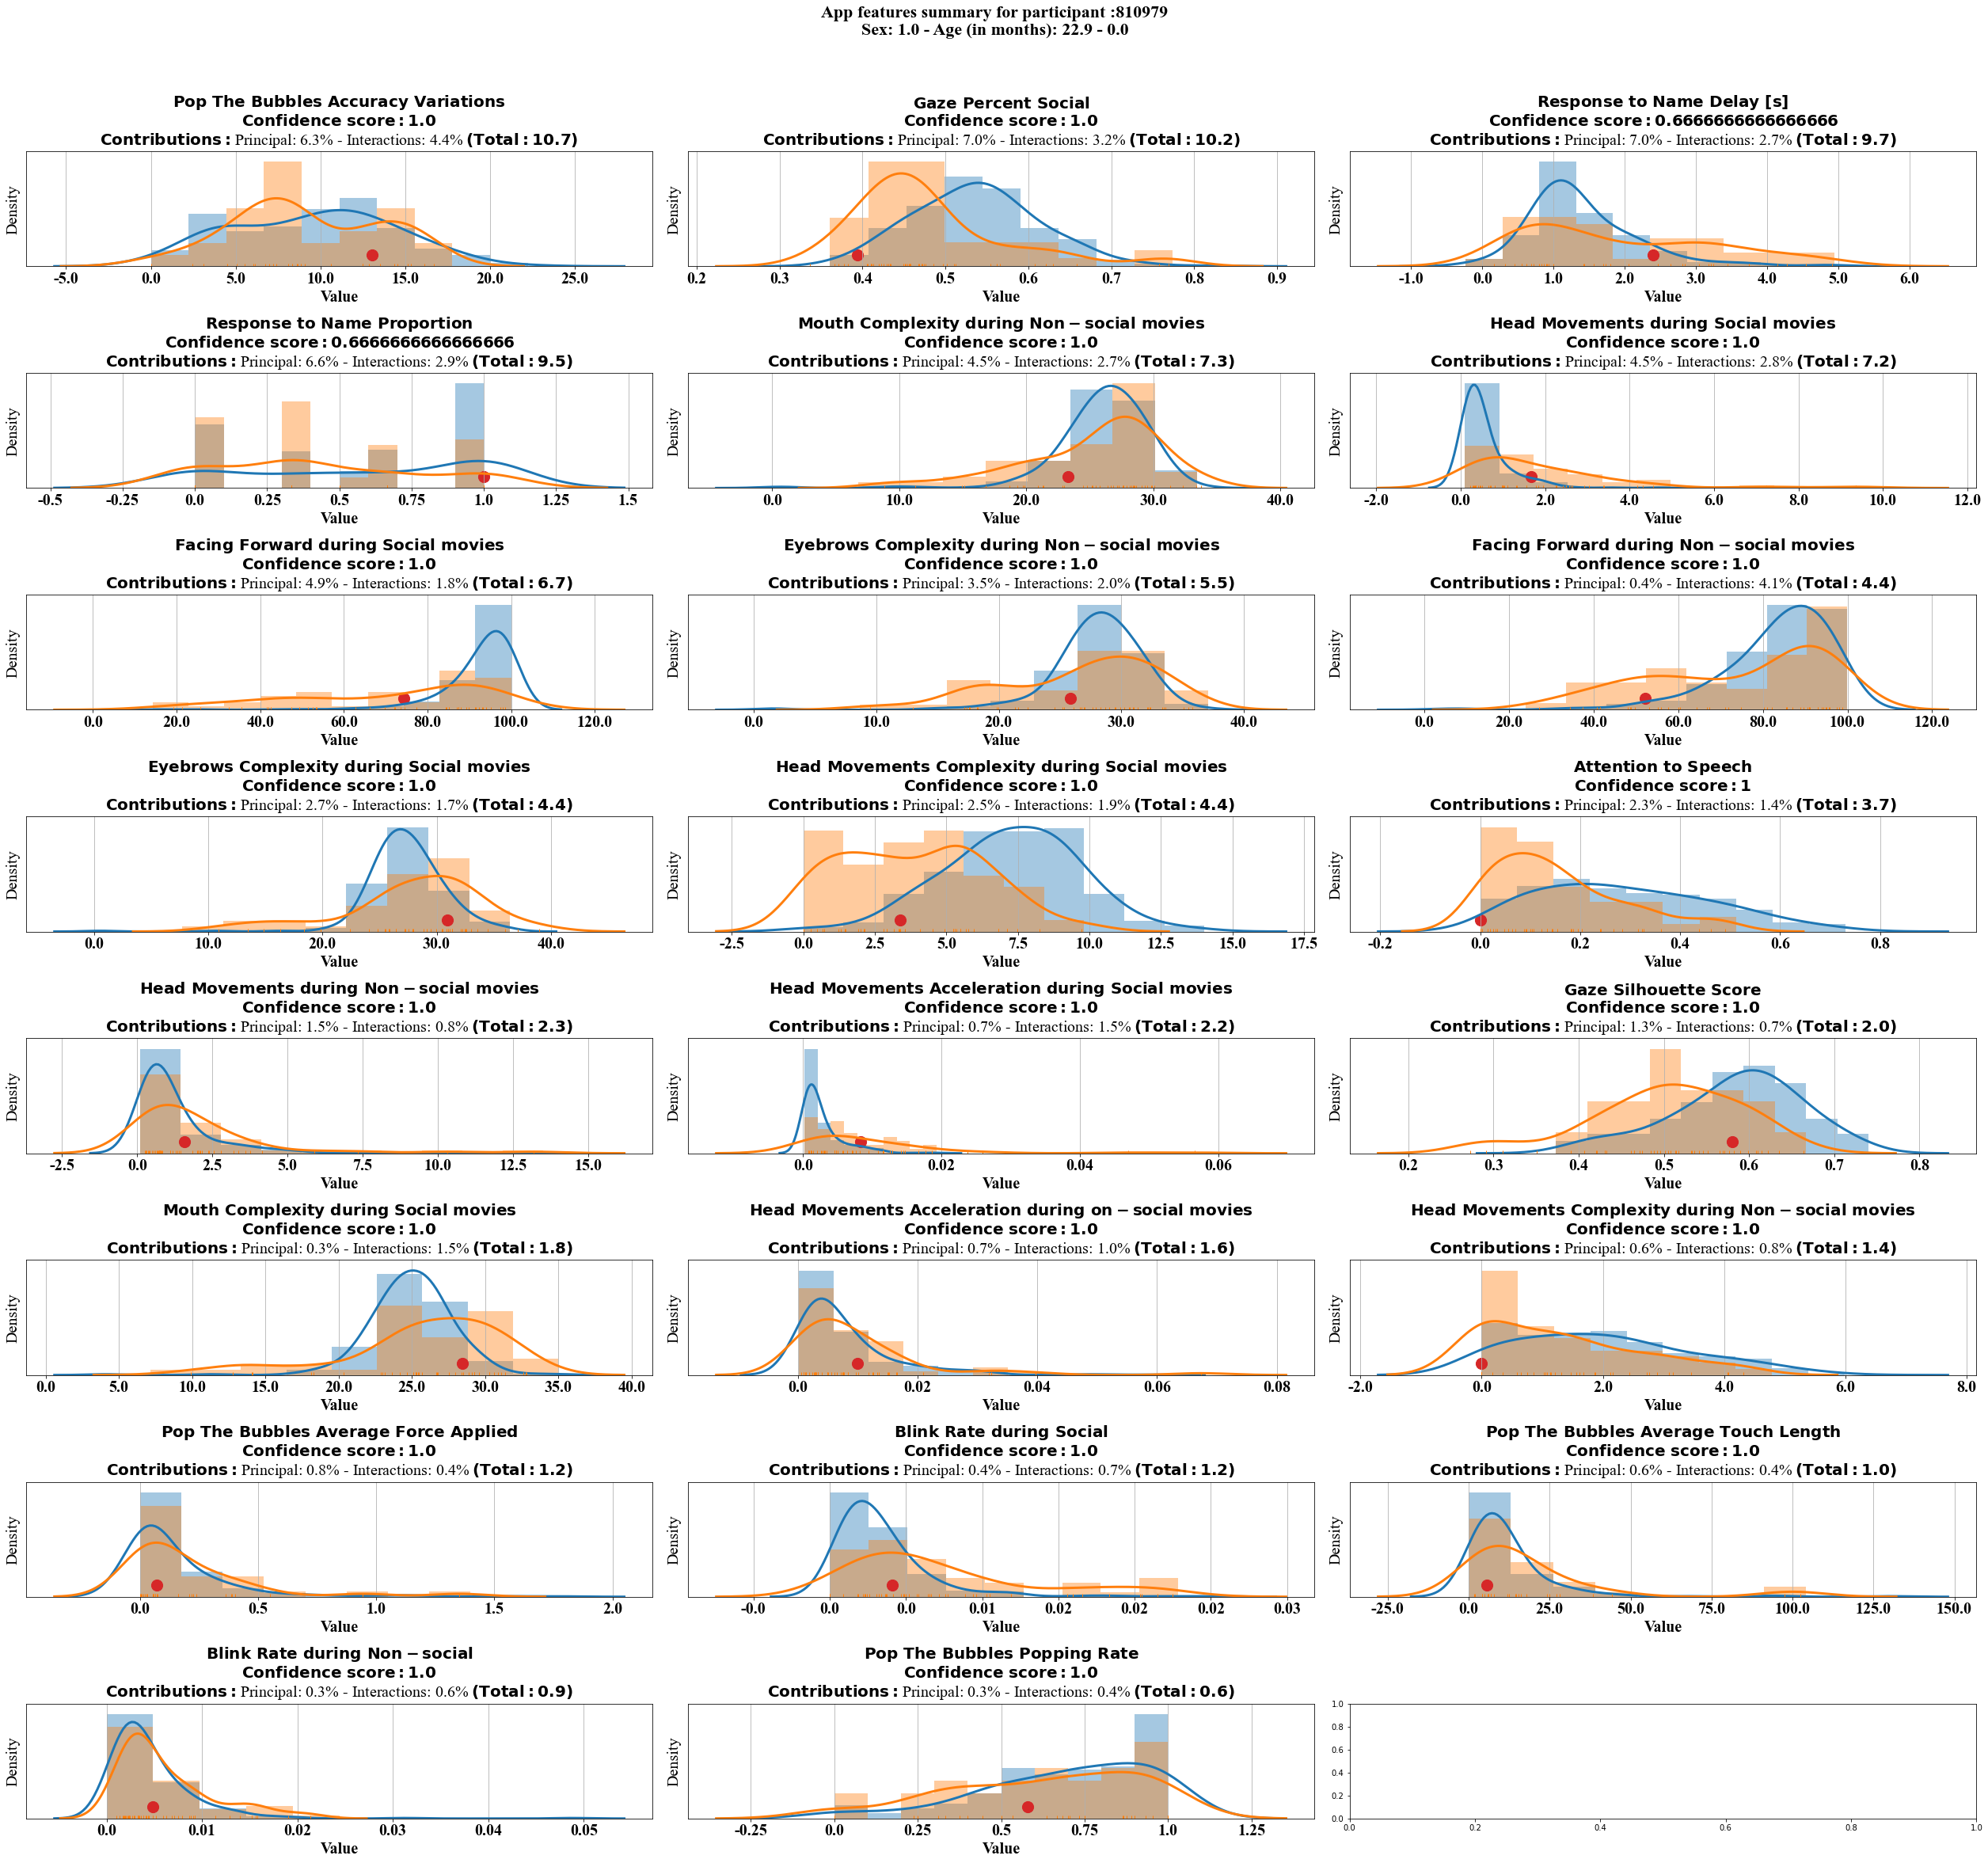

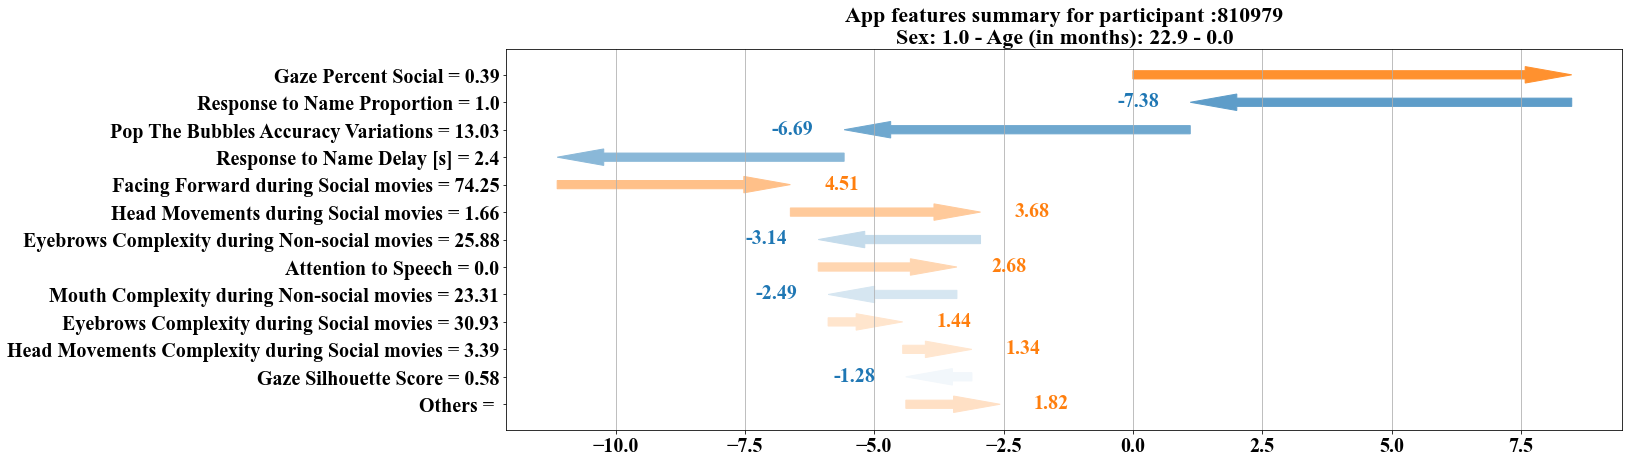

Gaze Percent Social: 1.00
Response to Name Proportion: 0.67
Pop The Bubbles Accuracy Variations: 1.00
Response to Name Delay [s]: 0.67
Facing Forward during Social movies: 1.00
Head Movements during Social movies: 1.00
Eyebrows Complexity during Non-social movies: 1.00
Attention to Speech: 1.00
Mouth Complexity during Non-social movies: 1.00
Eyebrows Complexity during Social movies: 1.00
Head Movements Complexity during Social movies: 1.00
Gaze Silhouette Score: 1.00



In [59]:
# FP with conclusiveness score of 1
index_sample = 107
display(exp.dataset.df.iloc[index_sample:index_sample+1][['quality_score', 'conslusiveness_score']])

report_participant(exp, index_sample)

quality_score  conslusiveness_score
272       0.933571                   0.0

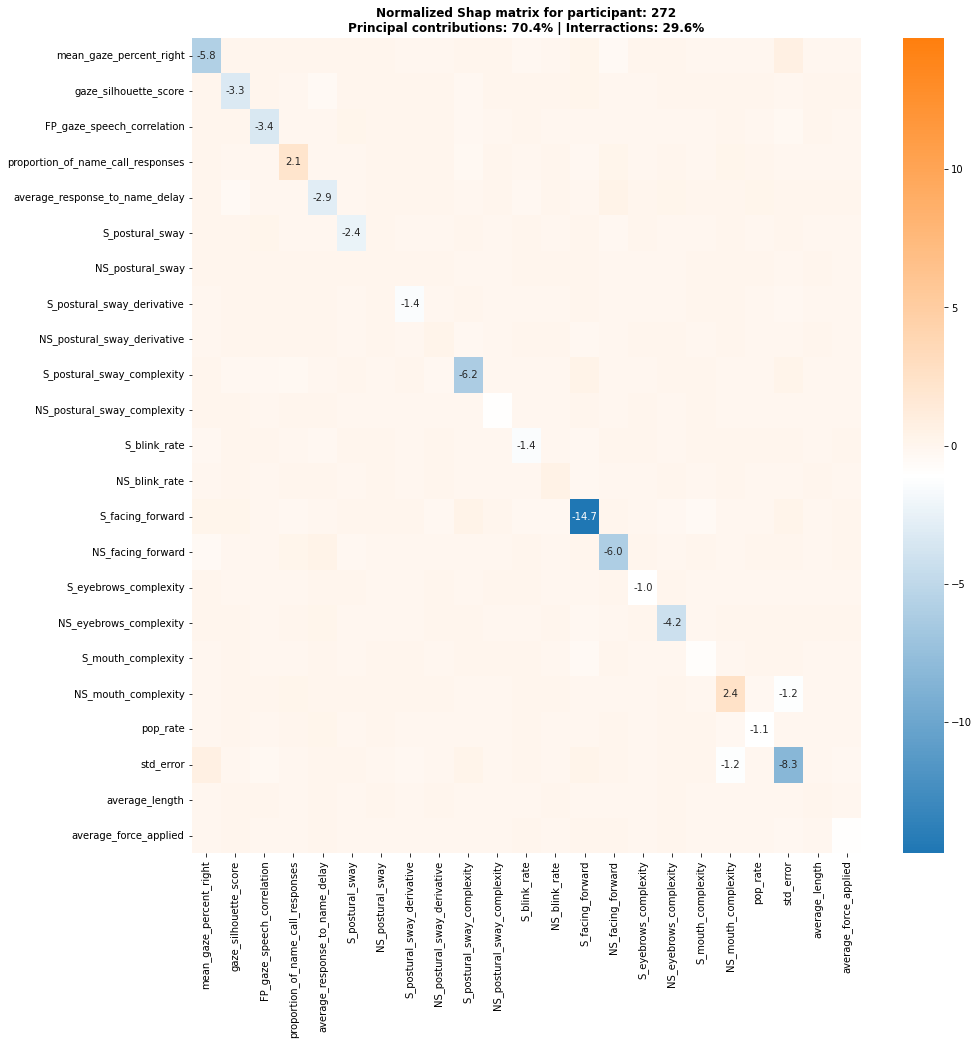

total       main interaction first_interaction          first_interaction_name
S_facing_forward                   17.354815  14.742445     2.61237          0.393864              S_mouth_complexity
std_error                          12.019361   8.304943    3.714418          1.241875             NS_mouth_complexity
S_postural_sway_complexity          8.120167   6.185238    1.934929          0.361016                S_facing_forward
mean_gaze_percent_right             8.108727   5.805516    2.303212          0.716532                       std_error
NS_facing_forward                   7.597607   6.018168    1.579439          0.441904  average_response_to_name_delay
NS_eyebrows_complexity              5.334002   4.159591    1.174411          0.188402                S_facing_forward
average_response_to_name_delay      5.086989    2.93166    2.155329          0.441904               NS_facing_forward
gaze_silhouette_score               4.619207   3.313691    1.305515          0.405506  average_response_to_name_delay
FP_gaze_speech_correlation          4.610196   3.389632    1.220564          0.297092                       std_error
NS_mouth_complexity                 4.570911   2.429652    2.141259          1.241875                       std_error
proportion_of_name_call_responses   3.539089   2.097173    1.441916          0.291335      S_postural_sway_complexity
S_postural_sway                     3.379743   2.369101    1.010641          0.122777               NS_facing_forward
S_postural_sway_derivative          2.404797    1.44939    0.955407          0.168571                       std_error
S_blink_rate                        2.302051   1.404925    0.897126          0.214548         mean_gaze_percent_right
pop_rate                            1.956284   1.134128    0.822156          0.154034  average_response_to_name_delay
average_force_applied               1.676472   0.923814    0.752658           0.21227                       std_error
S_mouth_complexity                   1.65424   0.813465    0.840775          0.393864                S_facing_forward
S_eyebrows_complexity               1.459361   1.049382    0.409979          0.082491  average_response_to_name_delay
NS_postural_sway_complexity         1.275704   0.960609    0.315095          0.046212                S_facing_forward
NS_postural_sway_derivative         1.128368   0.296615    0.831753          0.216673      S_postural_sway_complexity
NS_blink_rate                       1.079686   0.544962    0.534723          0.132519                S_facing_forward
NS_postural_sway                    0.469527   0.053424    0.416102          0.061205                       std_error
average_length                      0.252696   0.046696       0.206          0.065722         mean_gaze_percent_right
SUM                                      100  70.424223   29.575777

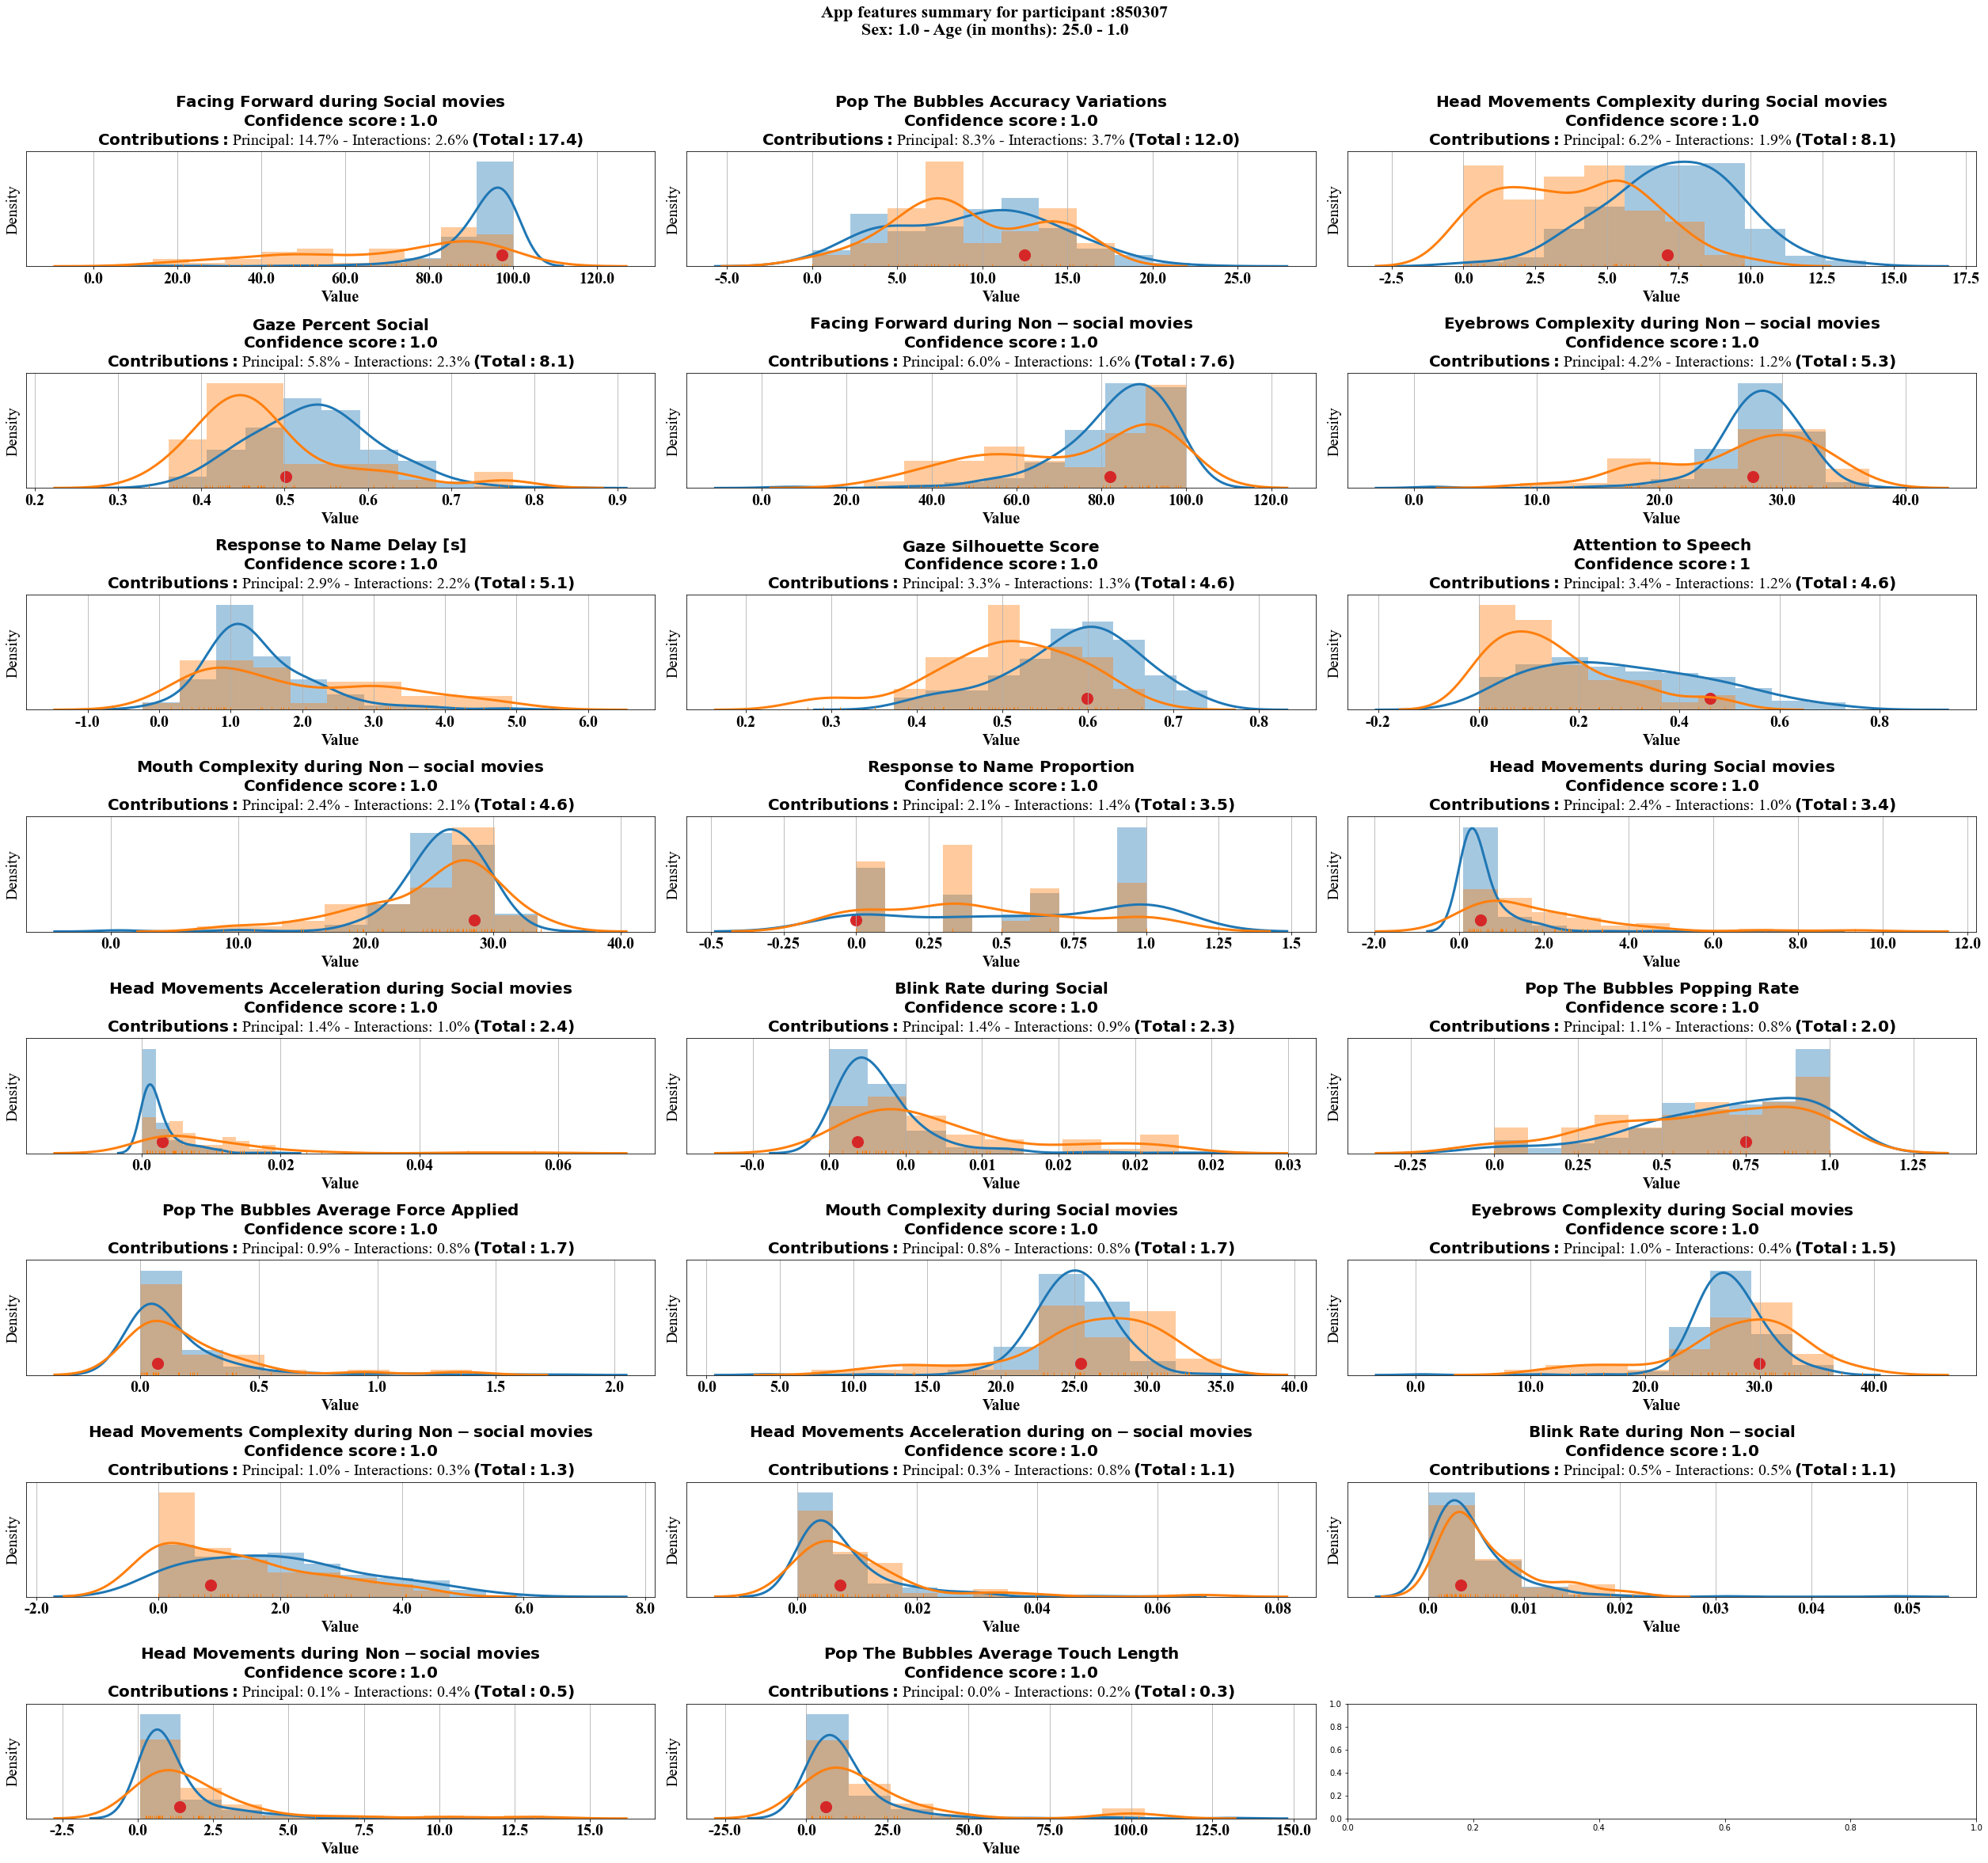

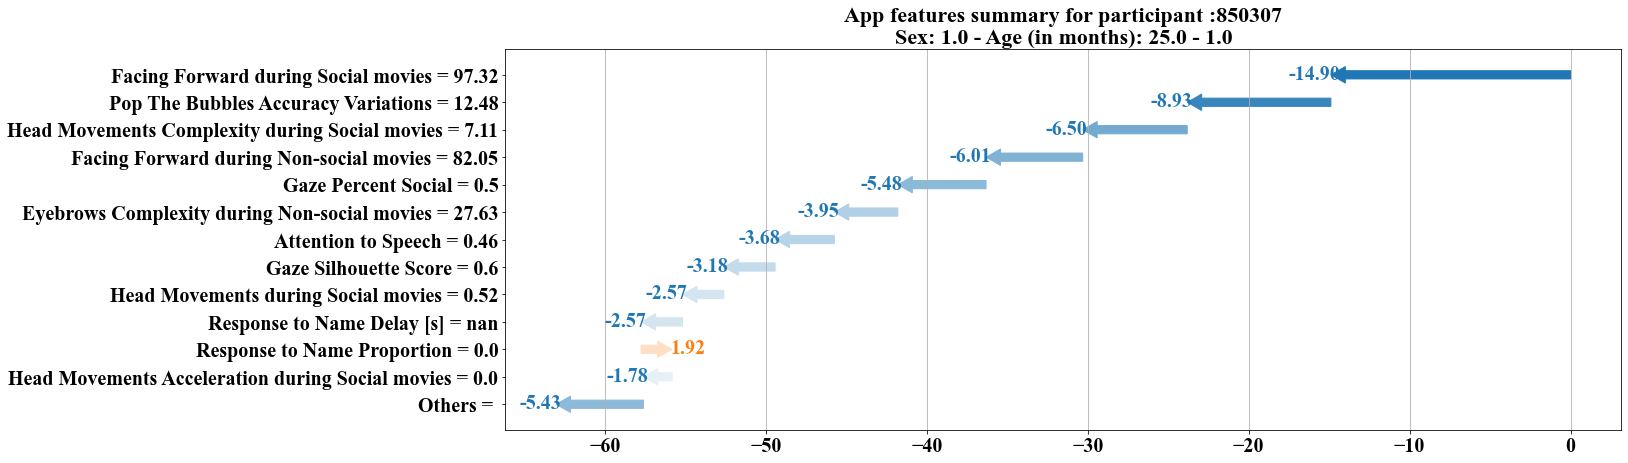

Facing Forward during Social movies: 1.00
Pop The Bubbles Accuracy Variations: 1.00
Head Movements Complexity during Social movies: 1.00
Facing Forward during Non-social movies: 1.00
Gaze Percent Social: 1.00
Eyebrows Complexity during Non-social movies: 1.00
Attention to Speech: 1.00
Gaze Silhouette Score: 1.00
Head Movements during Social movies: 1.00
Response to Name Delay [s]: 1.00
Response to Name Proportion: 1.00
Head Movements Acceleration during Social movies: 1.00



In [60]:
# FP with conclusiveness score of 1
index_sample = 272
display(exp.dataset.df.iloc[index_sample:index_sample+1][['quality_score', 'conslusiveness_score']])

report_participant(exp, index_sample)

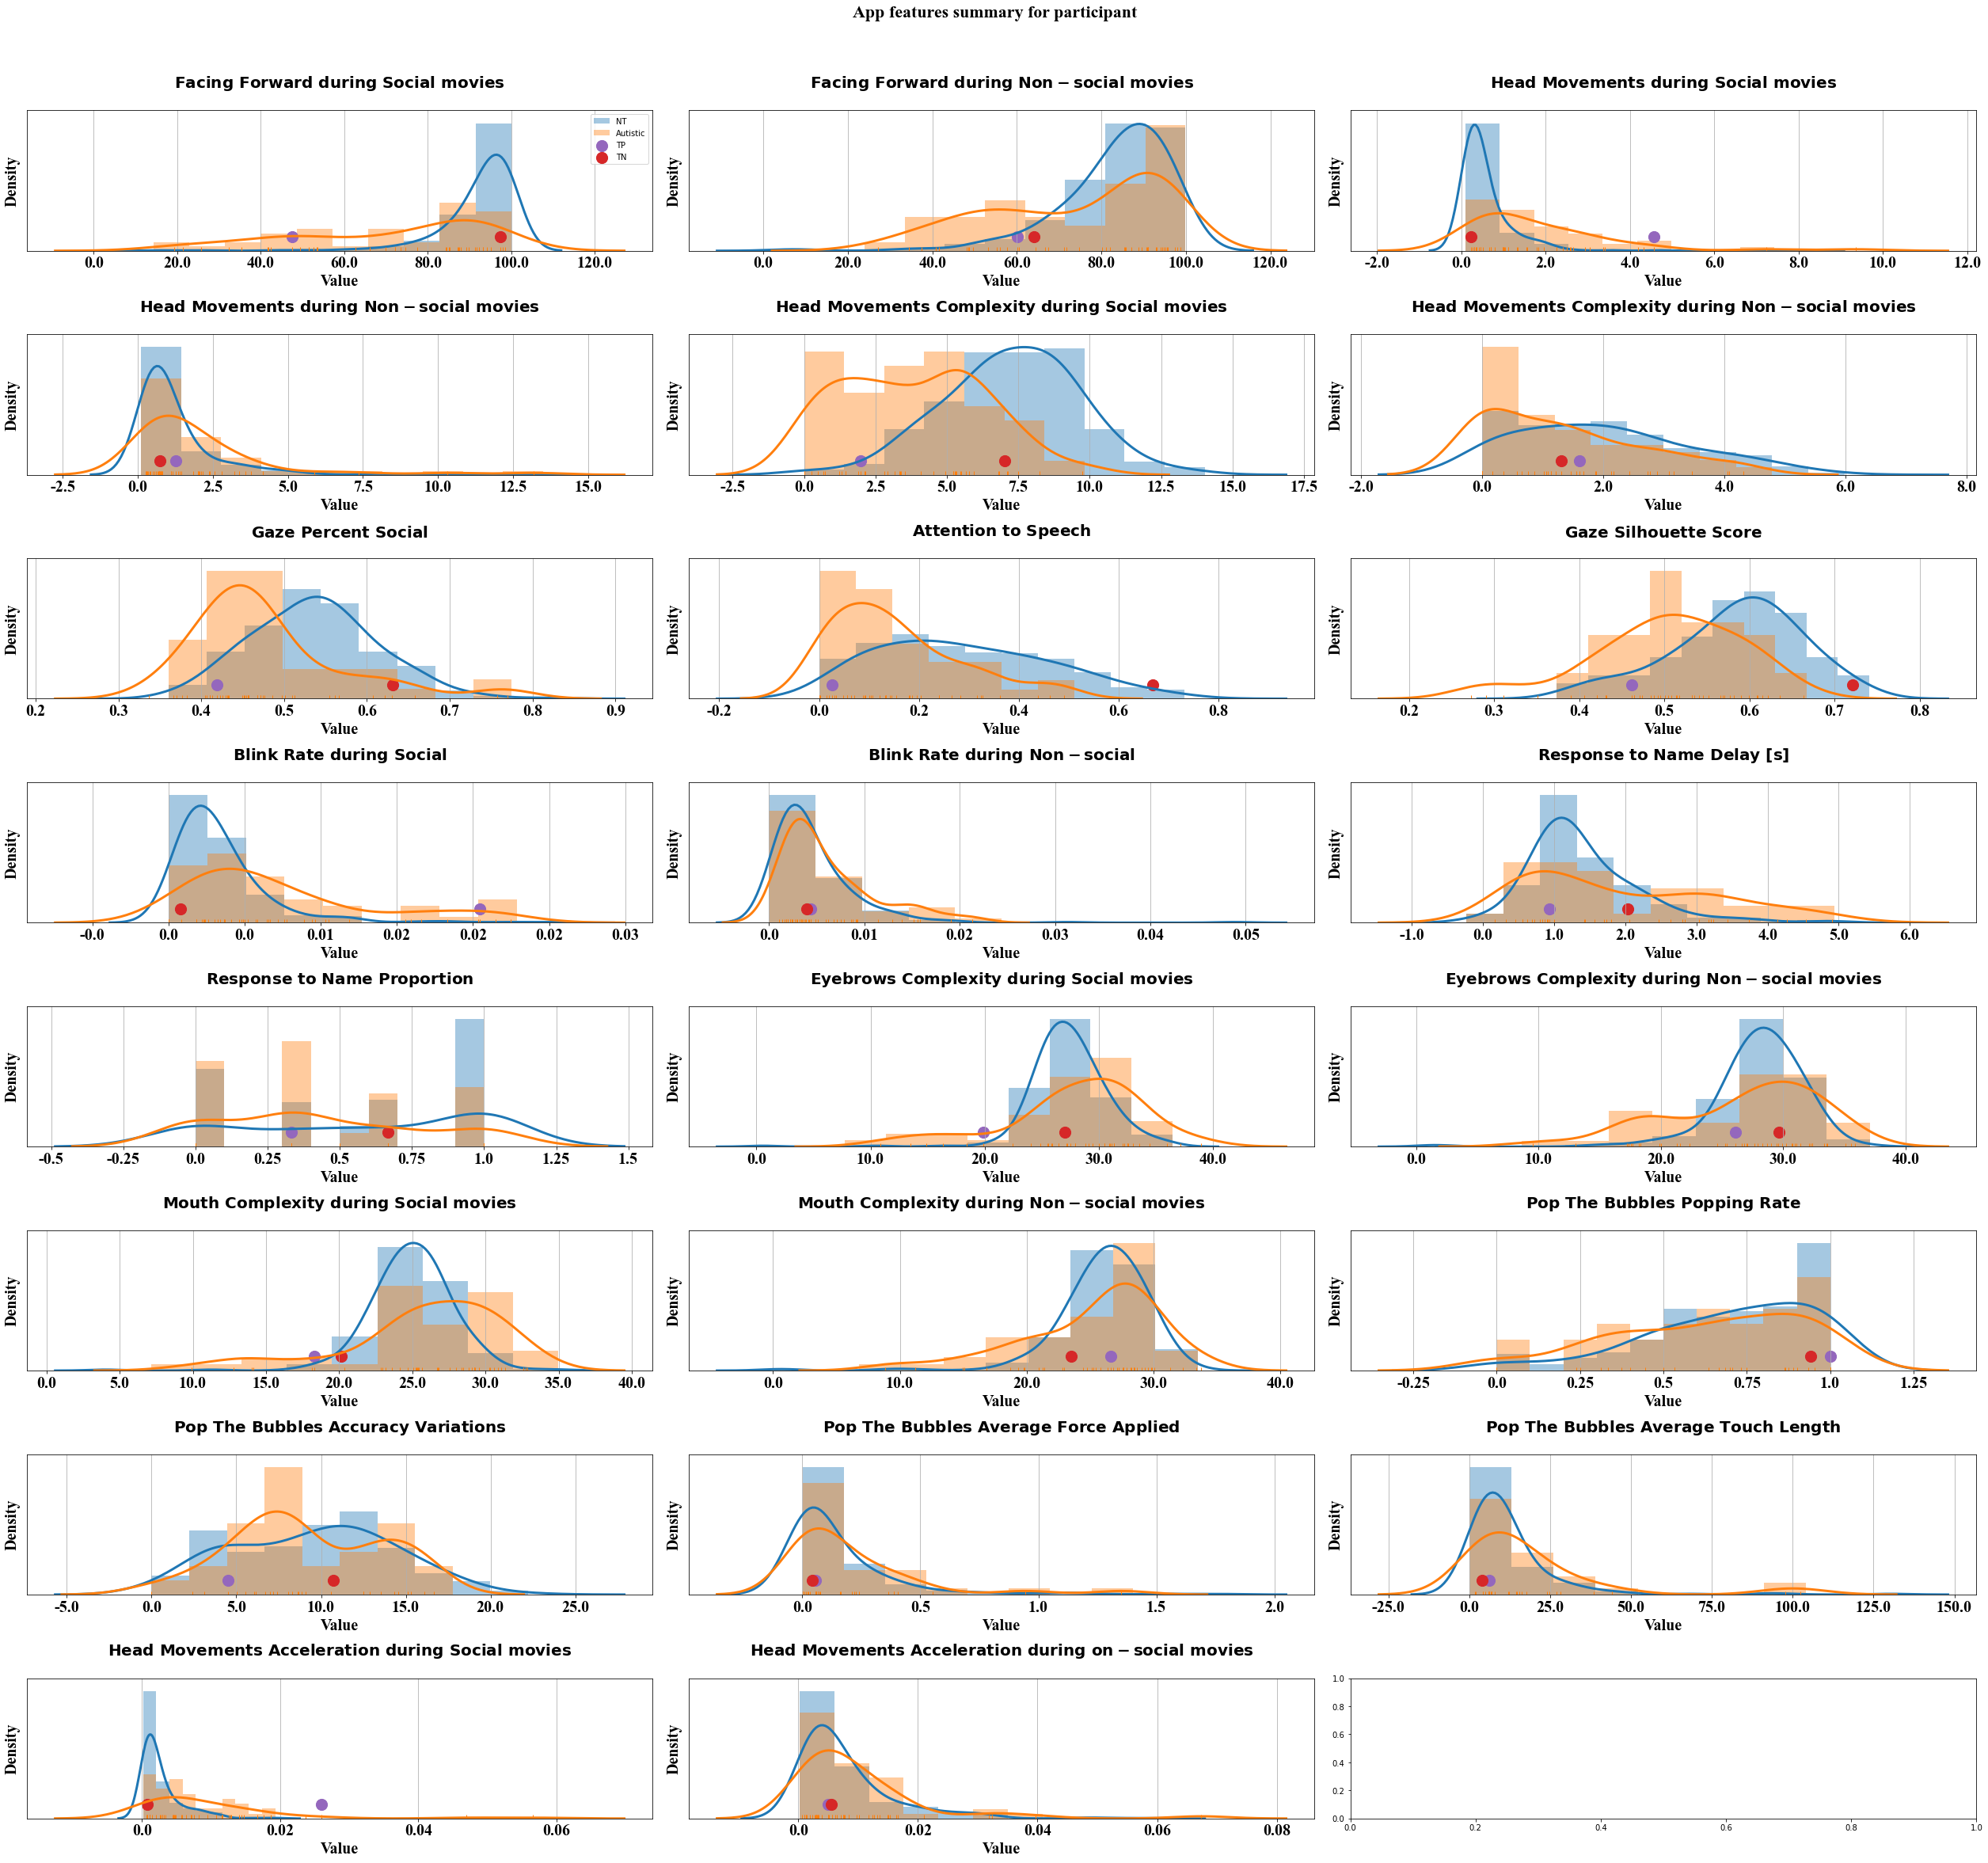

In [63]:
index_samples = [66, 165]


from utils import select
from matplotlib import rc
plt.rcParams["font.serif"] = "Times New Roman"

participant_id = exp.dataset.df.iloc[index_sample]['id']
age = exp.dataset.df.iloc[index_sample]['age']
sex = exp.dataset.df.iloc[index_sample]['sex']
diagnosis = exp.dataset.df.iloc[index_sample]['diagnosis']


n_plots = len(exp.features_name)
fig, axes = plt.subplots(n_plots//3+1, 3, figsize=(35, 32));axes = axes.flatten()
fig.suptitle("App features summary for participant", y=1.02, weight="bold", fontsize=22, **csfont)
for i, (feat, feature_name) in enumerate(feature_name_mapping.items()):

    title = r"$\bf{" + str(feature_name.replace(" ", "\ ")) + "}$\n"


    _, bins = np.histogram(select(exp.dataset.df, 'diagnosis', 0)[feat].dropna().to_numpy())
        
        
    sns.distplot(select(exp.dataset.df, 'diagnosis', 0)[feat].to_numpy(), bins=bins, label='NT',  color='tab:blue', ax=axes[i], kde_kws=dict(bw=0.4, lw=3))
    sns.distplot(select(exp.dataset.df, 'diagnosis', 1)[feat].to_numpy(), bins=bins, label='Autistic', rug=True,  color='tab:orange', ax=axes[i], kde_kws=dict(bw=0.4, lw=3))
    axes[i].set_title(title, fontsize=20, **csfont); axes[i].set_xlabel("Value", weight='bold', fontsize=20, **csfont)
    axes[i].set_yticks([]); axes[i].grid();y_min, y_max = axes[i].get_ylim(); axes[i].set_ylabel("Density", weight='bold', fontsize=20, **csfont)
    axes[i].set_xticks(axes[i].get_xticks(), np.round(axes[i].get_xticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)


    axes[i].scatter([exp.dataset.df.iloc[index_samples[0]][feat]], [0.1*(y_max-y_min)], s=200, color='#9467bd', label='TP')
    axes[i].scatter([exp.dataset.df.iloc[index_samples[1]][feat]], [0.1*(y_max-y_min)], s=200, color='#d62728', label='TN')
    
axes[0].legend()
plt.tight_layout()
plt.savefig(os.path.join(ROOT_DIR, 'figures_final', 'participants_summary.png'), dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:
matrix_shap = averaged_shap_interactions_normalized[index_sample]*100


In [11]:
index_samples = [165, 66, 47, 107, 272]

from utils import select
from matplotlib import rc
plt.rcParams["font.serif"] = "Times New Roman"

for index_sample in index_samples:
    participant_id = exp.dataset.df.iloc[index_sample]['id']
    
    display(exp.dataset.df.iloc[index_sample: index_sample+1])

id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking        age timestamp       date   time study stimuli_version  sex  ethnicity  race  primary_education  asd_yn  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay valid_name_calls  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  MP_postural_sway  \
165  811600        0.0  English         2.0  <Subject.S2KSubject object at 0x7fea923b22d0>  <Administration.S2KAdministration object at 0x...                   1              1  24.983607    Admin1 2020-01-23  00:00    P1       Preschool  1.0        0.0   0.0                4.0     NaN        NaN        NaN        NaN        NaN             NaN         NaN       NaN      NaN               NaN                          NaN                           NaN                 0.0             0.0          0.0          0.0           0.0               0.338641                  0.645915              0.600262                 0.796307                    0.668531                  0.802997                           0.666667                        2.035367        [1, 1, 1]          0.882712                     0.008357            0.834522                        0.00389               0.85953                         0.008628          0.250019                     0.000941          0.338163   

     MP_postural_sway_derivative  PB_postural_sway  PB_postural_sway_derivative  BB_postural_sway  BB_postural_sway_derivative  RT_postural_sway  RT_postural_sway_derivative  MML_postural_sway  MML_postural_sway_derivative  PWB_postural_sway  PWB_postural_sway_derivative  FP_postural_sway  FP_postural_sway_derivative  number_of_touches  average_length  std_length  average_error  std_error  number_of_target  pop_rate  average_touch_duration  std_touch_duration  average_delay_to_pop  std_delay_to_pop  repeat_percentage  repeat_percentage_naive  double_tap  mean_velocity  std_velocity  average_force_applied  std_force_applied  average_accuracy_variation  accuracy_consistency  average_touches_per_target  std_touches_per_target  average_time_spent  std_time_spent  exploratory_percentage  validity_available  completed  StateOfTheChild  SiblingsInTheRoom ShotsVaccines  Distractions  FamilyMemberDistract  PetDistract  PetNoiseDistract  DoorbellPhoneDistract  TVOnDistract  OtherDistract  \
165                      0.00129               NaN                          NaN          0.195057                     0.000562          0.295745                     0.001156           0.190638                      0.000428           0.253548                      0.000762          0.298669                      0.00103               34.0        4.050845    4.086666      10.887405  10.705549              12.0  0.941176                0.068529            0.064109              2.274667          0.504807           0.153846                 0.882353    1.666667       0.068529      0.064109               0.042878           0.081725                    0.011715              0.171036                    2.833333                0.687184            0.742917        0.299345               55.555556                   1        0.0              1.0                0.0             1           0.0                   0.0          0.0               0.0                    0.0           0.0            0.0   

     SittingUp  Hungry  Diaper AppTeamComme

id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking        age timestamp       date   time study stimuli_version  sex  ethnicity  race  primary_education  asd_yn  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay valid_name_calls  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  MP_postural_sway  \
66  810366        1.0  Spanish         2.0  <Subject.S2KSubject object at 0x7fead9080a10>  <Administration.S2KAdministration object at 0x...                   1              1  30.590164    Admin1 2019-11-25  00:00   ARC       Preschool  0.0        1.0   2.0                4.0     NaN       20.0       47.0       20.0       42.0            67.0         9.0       7.0     10.0              40.0                         43.0                          45.0                 9.0            11.0          4.0          2.0           1.0               0.471018                  0.453293              0.309696                  0.47038                    0.025305                  0.442802                           0.333333                        0.934267        [1, 1, 1]          1.451842                     0.006917            2.575564                       0.008743              0.582684                         0.001915          3.070359                     0.012738          0.490197   

    MP_postural_sway_derivative  PB_postural_sway  PB_postural_sway_derivative  BB_postural_sway  BB_postural_sway_derivative  RT_postural_sway  RT_postural_sway_derivative  MML_postural_sway  MML_postural_sway_derivative  PWB_postural_sway  PWB_postural_sway_derivative  FP_postural_sway  FP_postural_sway_derivative  number_of_touches  average_length  std_length  average_error  std_error  number_of_target  pop_rate  average_touch_duration  std_touch_duration  average_delay_to_pop  std_delay_to_pop  repeat_percentage  repeat_percentage_naive  double_tap  mean_velocity  std_velocity  average_force_applied  std_force_applied  average_accuracy_variation  accuracy_consistency  average_touches_per_target  std_touches_per_target  average_time_spent  std_time_spent  exploratory_percentage  validity_available  completed  StateOfTheChild  SiblingsInTheRoom ShotsVaccines  Distractions  FamilyMemberDistract  PetDistract  PetNoiseDistract  DoorbellPhoneDistract  TVOnDistract  OtherDistract  \
66                     0.002475               NaN                          NaN          0.280094                     0.001128          3.875919                     0.021672           8.435855                      0.073183            2.79036                      0.008342          8.222721                     0.034268                6.0        6.071926    7.484722       6.745409   4.490219               6.0       1.0                0.096667            0.071786                2.2075          0.830756                0.0                      0.5         0.0       0.096667      0.071786               0.055451           0.043417                    0.010545              0.030283                         1.0                     0.0                 NaN             NaN               44.444444                   1        0.0              1.0                1.0           NaN           0.0                   0.0          0.0               0.0                    0.0           0.0            0.0   

    SittingUp  Hungry  Diaper AppTeamComment C

id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking   age timestamp       date   time study stimuli_version  sex  ethnicity  race  primary_education  asd_yn  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay valid_name_calls  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  MP_postural_sway  \
47  810268        1.0  English         1.9  <Subject.S2KSubject object at 0x7fea925c92d0>  <Administration.S2KAdministration object at 0x...                   1              1  24.0    Admin1 2019-04-22  00:00    P1       Preschool  0.0        0.0   0.0                8.0     NaN       28.0       48.0       20.0       43.0            71.0         7.0       8.0      7.0              54.0                         54.0                          53.0                 1.0             2.0          NaN          NaN           NaN                0.54117                  0.489298              0.784155                 0.755249                    0.324038                  0.612218                           0.333333                        0.834167        [1, 1, 1]          1.160309                     0.005439            0.222091                         0.0004              0.948705                         0.005299          0.332451                     0.000946          0.301817   

    MP_postural_sway_derivative  PB_postural_sway  PB_postural_sway_derivative  BB_postural_sway  BB_postural_sway_derivative  RT_postural_sway  RT_postural_sway_derivative  MML_postural_sway  MML_postural_sway_derivative  PWB_postural_sway  PWB_postural_sway_derivative  FP_postural_sway  FP_postural_sway_derivative  number_of_touches  average_length  std_length  average_error  std_error  number_of_target  pop_rate  average_touch_duration  std_touch_duration  average_delay_to_pop  std_delay_to_pop  repeat_percentage  repeat_percentage_naive  double_tap  mean_velocity  std_velocity  average_force_applied  std_force_applied  average_accuracy_variation  accuracy_consistency  average_touches_per_target  std_touches_per_target  average_time_spent  std_time_spent  exploratory_percentage  validity_available  completed  StateOfTheChild  SiblingsInTheRoom ShotsVaccines  Distractions  FamilyMemberDistract  PetDistract  PetNoiseDistract  DoorbellPhoneDistract  TVOnDistract  OtherDistract  \
47                     0.000802               NaN                          NaN          0.314693                     0.000882          1.340824                     0.005986           0.714322                      0.004029           1.093406                      0.004457          2.511567                       0.0065                NaN             NaN         NaN            NaN        NaN               NaN       NaN                     NaN                 NaN                   NaN               NaN                NaN                      NaN         NaN            NaN           NaN                    NaN                NaN                         NaN                   NaN                         NaN                     NaN                 NaN             NaN                     NaN                   1        0.0              3.0                0.0             1           0.0                   0.0          0.0               0.0                    0.0           0.0            0.0   

    SittingUp  Hungry  Diaper AppTeamComment Comments   

id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking        age timestamp       date   time study stimuli_version  sex  ethnicity  race  primary_education  asd_yn  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay valid_name_calls  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  MP_postural_sway  \
107  810979        0.0  English         2.0  <Subject.S2KSubject object at 0x7fead90ac510>  <Administration.S2KAdministration object at 0x...                   1              1  22.852459    Admin1 2019-08-22  00:00   ARC       Preschool  1.0        0.0   1.0                3.0     NaN       47.0       41.0       20.0       44.0            77.0         5.0       7.0      4.0               NaN                          NaN                           NaN                 1.0             2.0          0.0          0.0           0.0               0.674227                  0.554673              0.462633                 0.605624                         0.0                  0.680947                                1.0                          2.4024        [1, 1, 0]          1.057283                     0.010737            1.180499                       0.010102              1.720305                         0.008074          1.842152                     0.010203           2.38286   

     MP_postural_sway_derivative  PB_postural_sway  PB_postural_sway_derivative  BB_postural_sway  BB_postural_sway_derivative  RT_postural_sway  RT_postural_sway_derivative  MML_postural_sway  MML_postural_sway_derivative  PWB_postural_sway  PWB_postural_sway_derivative  FP_postural_sway  FP_postural_sway_derivative  number_of_touches  average_length  std_length  average_error  std_error  number_of_target  pop_rate  average_touch_duration  std_touch_duration  average_delay_to_pop  std_delay_to_pop  repeat_percentage  repeat_percentage_naive  double_tap  mean_velocity  std_velocity  average_force_applied  std_force_applied  average_accuracy_variation  accuracy_consistency  average_touches_per_target  std_touches_per_target  average_time_spent  std_time_spent  exploratory_percentage  validity_available  completed  StateOfTheChild  SiblingsInTheRoom ShotsVaccines  Distractions  FamilyMemberDistract  PetDistract  PetNoiseDistract  DoorbellPhoneDistract  TVOnDistract  OtherDistract  \
107                      0.01091               NaN                          NaN          0.852572                     0.006742           1.34817                     0.008594           0.446586                      0.001875           0.750972                      0.003566          4.425273                     0.018866               38.0        5.658796    9.816935      18.908417  13.029292              12.0  0.578947                0.211868            0.568548                2.5465          0.785592           0.526316                 0.842105         1.2       0.211868      0.568548               0.070021           0.065186                    0.047832              0.390263                    2.666667                1.105542            0.899778        0.197832               88.888889                   1        0.0              1.0                0.0           NaN           0.0                   0.0          0.0               0.0                    0.0           0.0            0.0   

     SittingUp  Hungry  Diaper AppTeamComme

id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking        age timestamp       date   time study stimuli_version  sex  ethnicity  race  primary_education  asd_yn  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay valid_name_calls  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  MP_postural_sway  \
272  850307        1.0  English         2.0  <Subject.S2KSubject object at 0x7fead90706d0>  <Administration.S2KAdministration object at 0x...                   1              1  25.016393    Admin1 2020-01-15  00:00   ARC       Preschool  1.0        0.0   0.0                6.0     NaN       40.0       39.0       20.0       33.0            68.0         2.0       5.0      3.0              70.0                         68.0                          47.0                 7.0             9.0          5.0          3.0           1.0               0.416575                  0.500545              0.419738                 0.698047                    0.461882                  0.765603                                0.0                             NaN        [1, 1, 1]          0.559037                     0.003123            0.759209                       0.003985              3.427603                         0.015826          1.023526                     0.004506          0.824876   

     MP_postural_sway_derivative  PB_postural_sway  PB_postural_sway_derivative  BB_postural_sway  BB_postural_sway_derivative  RT_postural_sway  RT_postural_sway_derivative  MML_postural_sway  MML_postural_sway_derivative  PWB_postural_sway  PWB_postural_sway_derivative  FP_postural_sway  FP_postural_sway_derivative  number_of_touches  average_length  std_length  average_error  std_error  number_of_target  pop_rate  average_touch_duration  std_touch_duration  average_delay_to_pop  std_delay_to_pop  repeat_percentage  repeat_percentage_naive  double_tap  mean_velocity  std_velocity  average_force_applied  std_force_applied  average_accuracy_variation  accuracy_consistency  average_touches_per_target  std_touches_per_target  average_time_spent  std_time_spent  exploratory_percentage  validity_available  completed  StateOfTheChild  SiblingsInTheRoom ShotsVaccines  Distractions  FamilyMemberDistract  PetDistract  PetNoiseDistract  DoorbellPhoneDistract  TVOnDistract  OtherDistract  \
272                     0.005677               NaN                          NaN          0.294118                     0.001003          2.989522                     0.017525            0.30913                      0.001691           0.327622                      0.001163          0.624589                     0.006335               28.0        6.014059    6.169848      13.791358  12.478407              11.0      0.75                0.158143            0.136848                2.6459           0.80106           0.285714                 0.821429         1.1       0.158143      0.136848               0.071955           0.126226                    0.028445              0.350105                    2.363636                 1.06794            0.901375        0.356355               55.555556                   1        0.0              1.0                NaN           NaN           0.0                   0.0          0.0               0.0                    0.0           0.0            0.0   

     SittingUp  Hungry  Diaper AppTeamComme